In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np
import os
import json
from collections import defaultdict

import boto3

from scipy.stats import spearmanr, pearsonr

from regmixer.synthesize_mixture import calculate_priors
from regmixer.utils import config_from_path
from regmixer.eval.utils import (
    build_regression,
    get_output_dir,
    get_runs_from_api,
    mk_run_from_json,
    mk_run_metrics,
    mk_weights_from_config,
    mk_output_prefix,
    plot_correlation,
    #plot_weights,
    #simulate,
    simulate2,
    calculate_priors_with_manual,
    aggregate_mmlu
    )

from regmixer.eval.constants import (
    WandbMetrics,
    ObjectiveWeights,
)


import pathlib
import wandb


from regmixer.eval.constants import GroupedWandbMetrics


from regmixer.eval.law import ScalingLaw

In [3]:
config = "src/regmixer/config/superswarm_conditional_dclm.yaml"
launch_config = config_from_path(config)


priors = calculate_priors(
        source_configs=launch_config.sources,
        dtype=launch_config.dtype,
        use_cache=True,
    )

2025-06-10 13:29:52,467 - regmixer.synthesize_mixture - INFO - Source distribution cache found, using cached values! This can be disabled by setting use_cache=False.


In [44]:
config = "src/regmixer/config/superswarm_conditional_dclm.yaml"
launch_config = config_from_path(config)


old_priors = calculate_priors(
        source_configs=launch_config.sources,
        dtype=launch_config.dtype,
        use_cache=True,
    )

2025-06-09 17:13:46,823 - regmixer.synthesize_mixture - INFO - Source distribution cache found, using cached values! This can be disabled by setting use_cache=False.


In [257]:
config = "src/regmixer/config/superswarm_conditional_dclm_v2.yaml"
launch_config = config_from_path(config)


v2_priors = calculate_priors_with_manual(
        source_configs=launch_config.sources,
        dtype=launch_config.dtype,
        use_cache=False,
        manual_prior=launch_config.manual_prior,
    )

Counting tokens (leaf level):  12%|█▏        | 8/67 [00:10<01:01,  1.04s/it]2025-06-05 00:21:19,711 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: ai2-llm.s3.amazonaws.com. Connection pool size: 8
2025-06-05 00:21:19,734 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: ai2-llm.s3.amazonaws.com. Connection pool size: 8
2025-06-05 00:21:19,759 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: ai2-llm.s3.amazonaws.com. Connection pool size: 7
Counting tokens (leaf level):  21%|██        | 14/67 [00:13<00:25,  2.05it/s]2025-06-05 00:21:22,007 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: ai2-llm.s3.amazonaws.com. Connection pool size: 9
2025-06-05 00:21:22,011 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: ai2-llm.s3.amazonaws.com. Connection pool size: 9
Counting tokens (leaf level):  22%|██▏       | 15/67

In [262]:
sum(list({k: v for k, v in priors[2].items() if "pes2o" in k}.values()))

89767577562

In [261]:
{k: v for k, v in v2_priors[2].items() if "pes2o" in k}

{'pes2o': 58552461187}

In [4]:
def load_X_Y(experiment_groups, group_metrics, workspace, experiment_group_name, priors):
    BASE_CACHE_DIR = "cache/"

    if experiment_group_name is None:
        experiment_group_name = "_".join(experiment_groups)
        
    cache_path = pathlib.Path(BASE_CACHE_DIR) / f"{'_'.join(experiment_groups)}_{group_metrics}_runs_cache.json"
    api = wandb.Api() 

    num_samples=1

    eval_metric_group = GroupedWandbMetrics[group_metrics]
    eval_metric_group_name = group_metrics

    try:
        # TODO: Add partitioned cache per group maybe?
        with open(cache_path, "r") as f:
            run_dict = json.load(f)
            run_instances = [mk_run_from_json(run) for run in run_dict]

    except FileNotFoundError:
        run_instances = get_runs_from_api(
            api, workspace, experiment_groups, cache_path, True, num_samples, eval_metric_group
        )
            
    run_ratios = [
            {"run": run.id, "name": run.display_name, "index": idx, **mk_weights_from_config(run.config, priors)}
            for idx, run in enumerate(run_instances)
        ]

    run_metrics = []
    for idx, run in enumerate(run_instances):
        #if len(run.samples) == 0:
        #    continue 
        entry =    {
            "run": run.id,
            "name": run.display_name,
            "index": idx,
            **mk_run_metrics(
                history=run.samples,
                samples=num_samples,
                metrics=(eval_metric_group_name, eval_metric_group.value),
                display_name=run.display_name,
                average=False,
            ),
        }
        run_metrics.append(entry)

    ratios = pd.DataFrame(run_ratios)
    metrics = pd.DataFrame(run_metrics)
    ratios = ratios[ratios['run'].isin(metrics.run)]


    return ratios,  metrics


# Test loading in swarm and get MMLU aggregation weights

In [115]:
with open("cache/ee28fc9c_superswarm_offline_ratios.pkl", "rb") as f:
    ratios = pd.read_pickle(f)
with open("cache/ee28fc9c_superswarm_offline_metrics.pkl", "rb") as f:
    metrics = pd.read_pickle(f)

In [118]:

def add_weighted_dot_column(df: pd.DataFrame, weights: dict, output_col: str):
    weight_series = pd.Series(weights)
    df[output_col] = df[weight_series.index].dot(weight_series)
    df.drop(columns=weight_series.index, inplace=True)

stem_weights = {'mmlu_abstract_algebra:rc::olmes': 0.03313452617627568, 'mmlu_astronomy:rc::olmes': 0.05036447978793903, 'mmlu_college_biology:rc::olmes': 0.04771371769383698, 'mmlu_college_chemistry:rc::olmes': 0.03313452617627568, 'mmlu_college_computer_science:rc::olmes': 0.03313452617627568, 'mmlu_college_mathematics:rc::olmes': 0.03313452617627568, 'mmlu_college_physics:rc::olmes': 0.033797216699801194, 'mmlu_computer_security:rc::olmes': 0.03313452617627568, 'mmlu_conceptual_physics:rc::olmes': 0.07786613651424784, 'mmlu_electrical_engineering:rc::olmes': 0.04804506295559974, 'mmlu_elementary_mathematics:rc::olmes': 0.12524850894632206, 'mmlu_high_school_biology:rc::olmes': 0.10271703114645461, 'mmlu_high_school_chemistry:rc::olmes': 0.06726308813783963, 'mmlu_high_school_computer_science:rc::olmes': 0.03313452617627568, 'mmlu_high_school_mathematics:rc::olmes': 0.08946322067594434, 'mmlu_high_school_physics:rc::olmes': 0.050033134526176276, 'mmlu_high_school_statistics:rc::olmes': 0.07157057654075547, 'mmlu_machine_learning:rc::olmes': 0.03711066931742876}
other_weights = {'mmlu_anatomy:rc::olmes': 0.04164096236890808, 'mmlu_business_ethics:rc::olmes': 0.030845157310302282, 'mmlu_clinical_knowledge:rc::olmes': 0.08173966687230105, 'mmlu_college_medicine:rc::olmes': 0.05336212214682295, 'mmlu_global_facts:rc::olmes': 0.030845157310302282, 'mmlu_human_aging:rc::olmes': 0.06878470080197409, 'mmlu_management:rc::olmes': 0.03177051202961135, 'mmlu_marketing:rc::olmes': 0.07217766810610735, 'mmlu_medical_genetics:rc::olmes': 0.030845157310302282, 'mmlu_miscellaneous:rc::olmes': 0.24151758173966686, 'mmlu_nutrition:rc::olmes': 0.09438618136952498, 'mmlu_professional_accounting:rc::olmes': 0.08698334361505243, 'mmlu_professional_medicine:rc::olmes': 0.08389882788402221, 'mmlu_virology:rc::olmes': 0.05120296113510179}
social_sciences_weights = {'mmlu_econometrics:rc::olmes': 0.03704907377315567, 'mmlu_high_school_geography:rc::olmes': 0.06434839129021774, 'mmlu_high_school_government_and_politics:rc::olmes': 0.06272343191420214, 'mmlu_high_school_macroeconomics:rc::olmes': 0.12674683132921677, 'mmlu_high_school_microeconomics:rc::olmes': 0.07734806629834254, 'mmlu_high_school_psychology:rc::olmes': 0.17712057198570036, 'mmlu_human_sexuality:rc::olmes': 0.04257393565160871, 'mmlu_professional_psychology:rc::olmes': 0.19889502762430938, 'mmlu_public_relations:rc::olmes': 0.03574910627234319, 'mmlu_security_studies:rc::olmes': 0.07962300942476438, 'mmlu_sociology:rc::olmes': 0.0653233669158271, 'mmlu_us_foreign_policy:rc::olmes': 0.032499187520311994}
humanities_weights = {'mmlu_formal_logic:rc::olmes': 0.026780021253985122, 'mmlu_high_school_european_history:rc::olmes': 0.03506907545164718, 'mmlu_high_school_us_history:rc::olmes': 0.04335812964930925, 'mmlu_high_school_world_history:rc::olmes': 0.050371944739638685, 'mmlu_international_law:rc::olmes': 0.0257173219978746, 'mmlu_jurisprudence:rc::olmes': 0.022954303931987247, 'mmlu_logical_fallacies:rc::olmes': 0.034643995749202974, 'mmlu_moral_disputes:rc::olmes': 0.07353878852284804, 'mmlu_moral_scenarios:rc::olmes': 0.1902231668437832, 'mmlu_philosophy:rc::olmes': 0.06609989373007438, 'mmlu_prehistory:rc::olmes': 0.06886291179596174, 'mmlu_professional_law:rc::olmes': 0.32603613177470775, 'mmlu_world_religions:rc::olmes': 0.03634431455897981}

add_weighted_dot_column(metrics, stem_weights, "mmlu_stem")
add_weighted_dot_column(metrics, other_weights, "mmlu_other")
add_weighted_dot_column(metrics, social_sciences_weights, "mmlu_social_sciences")
add_weighted_dot_column(metrics, humanities_weights, "mmlu_humanities")


In [140]:
subset = ratios[ratios['name'].isin(
    metrics[metrics['arc_challenge:rc::olmes:full'] < 1.5].name
)]
domain_weights = subset.iloc[:, 3:]  # all domain columns
high_weight_counts = (domain_weights > 0.1).sum(axis=0)


regular = ratios.iloc[:, 3:]
regular_counts = (regular > 0.1).sum(axis=0)


In [139]:
high_weight_counts.sort_values(ascending=False)

dclm:science_math_and_technology    51
s2pdf:science_tech                  15
dclm:politics                        9
dclm:entertainment                   8
dclm:finance_and_business            8
                                    ..
s2pdf:politics                       0
s2pdf:religion                       0
s2pdf:software                       0
s2pdf:software_dev                   0
s2pdf:fashion_beauty                 0
Length: 64, dtype: int64

In [141]:
regular_counts.sort_values(ascending=False)

s2pdf:science_tech                  177
dclm:politics                       147
dclm:science_math_and_technology    115
dclm:entertainment                  109
dclm:health                         108
                                   ... 
s2pdf:games                           0
stack-edu:Go                          0
stack-edu:Cpp                         0
stack-edu:CSharp                      0
s2pdf:fashion_beauty                  0
Length: 64, dtype: int64

In [257]:
def get_offline_results(display_name, existing_results = None, dashboard="regmixer"):
    bucket = 'ai2-llm'
    prefix = f'evaluation/{dashboard}/{display_name}/'

    s3 = boto3.client('s3')

    # Get list of all files under the prefix
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

    json_files = []
    jsonl_files = []

    for page in pages:
        for obj in page.get('Contents', []):
            key = obj['Key']
            if not key.endswith('/'):
                if key.endswith('.jsonl'):
                    jsonl_files.append(key)
                elif key.endswith('.json'):
                    json_files.append(key)

    print(f"Found {len(json_files)} .json files and {len(jsonl_files)} .jsonl files.")

    all_jsonl_data = []

    for key in jsonl_files:
        if key.endswith("metrics-all.jsonl"):
            obj = s3.get_object(Bucket=bucket, Key=key)
            for line in obj['Body'].iter_lines():
                if line:
                    try:
                        data = json.loads(line.decode('utf-8'))
                        all_jsonl_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON line in {key}: {e}")

            print(f"Loaded JSONL: {key}")
            
    if existing_results is not None:
        offline_results = existing_results 
    else:
        offline_results = {}
    for data in all_jsonl_data:


        if "medmcqa" in data['task_name'] :
            print(data)

        if 'bits_per_byte_corr' in data['metrics']:
            if data['task_config']['metadata']['alias'] in offline_results:
                continue 
            offline_results[data['task_config']['metadata']['alias']] = data['metrics']['bits_per_byte_corr']
        elif 'bits_per_byte_corr_macro' in data['metrics']:
            if data['task_config']['metadata']['alias'] in offline_results:
                continue 
            offline_results[data['task_config']['metadata']['alias']] = data['metrics']['bits_per_byte_corr_macro']
        elif 'bits_per_byte' in data['metrics']:
            if data['task_name'] in offline_results:
                continue 
            offline_results[data['task_name']] = data['metrics']['bits_per_byte'] 
        else:
            print(data['task_name'])
            print(data['metrics'].keys())

    return offline_results


In [251]:
display_names = [f"5xC-30m-superswarm-ee28fc9c-{i:04d}_step22100-hf" for i in range(0, 1)]


In [258]:
all_offline_results = {}
for i, display_name in enumerate(display_names):
    #all_offline_results[display_name] = get_offline_results(display_name, existing_results=all_offline_results[display_name])
    all_offline_results[display_name] = get_offline_results(display_name)


Found 123 .json files and 337 .jsonl files.
Loaded JSONL: evaluation/regmixer/5xC-30m-superswarm-ee28fc9c-0000_step22100-hf/arc_challenge_rc_olmes_full-arc_easy_rc_olm-7e998a/metrics-all.jsonl
Loaded JSONL: evaluation/regmixer/5xC-30m-superswarm-ee28fc9c-0000_step22100-hf/codex_humaneval_3shot_bpb_none-coqa_rc_bpb_-6fb076/metrics-all.jsonl
Loaded JSONL: evaluation/regmixer/5xC-30m-superswarm-ee28fc9c-0000_step22100-hf/minerva_math_counting_and_probability_olmes-7c4185/metrics-all.jsonl
Loaded JSONL: evaluation/regmixer/5xC-30m-superswarm-ee28fc9c-0000_step22100-hf/mmlu_business_ethics_rc_olmes-mmlu_clinical-48b293/metrics-all.jsonl
Loaded JSONL: evaluation/regmixer/5xC-30m-superswarm-ee28fc9c-0000_step22100-hf/mmlu_computer_security_rc_olmes-mmlu_concep-6580bd/metrics-all.jsonl
Loaded JSONL: evaluation/regmixer/5xC-30m-superswarm-ee28fc9c-0000_step22100-hf/mmlu_high_school_chemistry_rc_olmes-mmlu_hi-a5a344/metrics-all.jsonl
Loaded JSONL: evaluation/regmixer/5xC-30m-superswarm-ee28fc9c-

In [39]:
results_df = pd.DataFrame(all_offline_results).T


In [ ]:
_subcategories = {
    "abstract_algebra": ["math"],
    "anatomy": ["health"],
    "astronomy": ["physics"],
    "business_ethics": ["business"],
    "clinical_knowledge": ["health"],
    "college_biology": ["biology"],
    "college_chemistry": ["chemistry"],
    "college_computer_science": ["computer science"],
    "college_mathematics": ["math"],
    "college_medicine": ["health"],
    "college_physics": ["physics"],
    "computer_security": ["computer science"],
    "conceptual_physics": ["physics"],
    "econometrics": ["economics"],
    "electrical_engineering": ["engineering"],
    "elementary_mathematics": ["math"],
    "formal_logic": ["philosophy"],
    "global_facts": ["other"],
    "high_school_biology": ["biology"],
    "high_school_chemistry": ["chemistry"],
    "high_school_computer_science": ["computer science"],
    "high_school_european_history": ["history"],
    "high_school_geography": ["geography"],
    "high_school_government_and_politics": ["politics"],
    "high_school_macroeconomics": ["economics"],
    "high_school_mathematics": ["math"],
    "high_school_microeconomics": ["economics"],
    "high_school_physics": ["physics"],
    "high_school_psychology": ["psychology"],
    "high_school_statistics": ["math"],
    "high_school_us_history": ["history"],
    "high_school_world_history": ["history"],
    "human_aging": ["health"],
    "human_sexuality": ["culture"],
    "international_law": ["law"],
    "jurisprudence": ["law"],
    "logical_fallacies": ["philosophy"],
    "machine_learning": ["computer science"],
    "management": ["business"],
    "marketing": ["business"],
    "medical_genetics": ["health"],
    "miscellaneous": ["other"],
    "moral_disputes": ["philosophy"],
    "moral_scenarios": ["philosophy"],
    "nutrition": ["health"],
    "philosophy": ["philosophy"],
    "prehistory": ["history"],
    "professional_accounting": ["other"],
    "professional_law": ["law"],
    "professional_medicine": ["health"],
    "professional_psychology": ["psychology"],
    "public_relations": ["politics"],
    "security_studies": ["politics"],
    "sociology": ["culture"],
    "us_foreign_policy": ["politics"],
    "virology": ["health"],
    "world_religions": ["philosophy"],
}

_categories = {
    "stem": ["physics", "chemistry", "biology", "computer science", "math", "engineering"],
    "humanities": ["history", "philosophy", "law"],
    "social_sciences": ["politics", "culture", "economics", "geography", "psychology"],
    "other": ["other", "business", "health"],
}


In [9]:
category_to_subcategories = defaultdict(list)
topic_to_category = {}
for cat, topics in _categories.items():
    for topic in topics:
        topic_to_category[topic] = cat

# Build it by iterating over subcategories
for subcat, topics in _subcategories.items():
    for topic in topics:
        category = topic_to_category[topic]
        category_to_subcategories[category].append("mmlu_" + subcat)

# Convert to regular dict
category_to_subcategories = dict(category_to_subcategories)


In [10]:
mmlu_subcategories = ['mmlu_abstract_algebra',
       'mmlu_anatomy', 'mmlu_astronomy', 'mmlu_business_ethics',
       'mmlu_clinical_knowledge', 'mmlu_college_biology',
       'mmlu_college_chemistry', 'mmlu_college_computer_science',
       'mmlu_college_mathematics', 'mmlu_college_medicine',
       'mmlu_college_physics', 'mmlu_computer_security',
       'mmlu_conceptual_physics', 'mmlu_econometrics',
       'mmlu_electrical_engineering', 'mmlu_elementary_mathematics',
       'mmlu_formal_logic', 'mmlu_global_facts', 'mmlu_high_school_biology',
       'mmlu_high_school_chemistry', 'mmlu_high_school_computer_science',
       'mmlu_high_school_european_history', 'mmlu_high_school_geography',
       'mmlu_high_school_government_and_politics',
       'mmlu_high_school_macroeconomics', 'mmlu_high_school_mathematics',
       'mmlu_high_school_microeconomics', 'mmlu_high_school_physics',
       'mmlu_high_school_psychology', 'mmlu_high_school_statistics',
       'mmlu_high_school_us_history', 'mmlu_high_school_world_history',
       'mmlu_human_aging', 'mmlu_human_sexuality', 'mmlu_international_law',
       'mmlu_jurisprudence', 'mmlu_logical_fallacies', 'mmlu_machine_learning',
       'mmlu_management', 'mmlu_marketing', 'mmlu_medical_genetics',
       'mmlu_miscellaneous', 'mmlu_moral_disputes', 'mmlu_moral_scenarios',
       'mmlu_nutrition', 'mmlu_philosophy', 'mmlu_prehistory',
       'mmlu_professional_accounting', 'mmlu_professional_law',
       'mmlu_professional_medicine', 'mmlu_professional_psychology',
       'mmlu_public_relations', 'mmlu_security_studies', 'mmlu_sociology',
       'mmlu_us_foreign_policy', 'mmlu_virology', 'mmlu_world_religions',]

mmlu_subcategories = [cat.split("mmlu_")[-1] for cat in mmlu_subcategories]

In [11]:
from datasets import load_dataset

sizes = {}
for cat in mmlu_subcategories:
    print(cat)
    data = load_dataset("hails/mmlu_no_train", cat, split="test")
    sizes[cat] = len(data)


abstract_algebra


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

anatomy


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

astronomy


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

business_ethics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

clinical_knowledge


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

college_biology


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

college_chemistry


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

college_computer_science


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

college_mathematics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

college_medicine


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

college_physics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

computer_security


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

conceptual_physics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

econometrics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

electrical_engineering


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

elementary_mathematics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

formal_logic


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

global_facts


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_biology


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_chemistry


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_computer_science


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_european_history


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_geography


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_government_and_politics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_macroeconomics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_mathematics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_microeconomics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_physics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_psychology


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_statistics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_us_history


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

high_school_world_history


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

human_aging


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

human_sexuality


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

international_law


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

jurisprudence


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

logical_fallacies


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

machine_learning


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

management


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

marketing


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

medical_genetics


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

miscellaneous


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

moral_disputes


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

moral_scenarios


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

nutrition


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

philosophy


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

prehistory


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

professional_accounting


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

professional_law


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

professional_medicine


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

professional_psychology


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

public_relations


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

security_studies


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

sociology


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

us_foreign_policy


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

virology


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

world_religions


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

In [24]:
for cat in category_to_subcategories:
    print(cat)
    sizes_cat = {subcats: sizes[subcats.split("mmlu_")[-1]] for subcats in category_to_subcategories[cat]}
    total = np.array(list(sizes_cat.values())).sum()
    sizes_cat = {subcat + ":rc::olmes": weight/total for subcat, weight in sizes_cat.items()}

    print(sizes_cat)
    #sizes_cat = np.array([sizes[subcats.split("mmlu_")[-1]] for subcats in category_to_subcategories[cat]])

    #weights = sizes_cat / np.sum(sizes_cat)
    #results_df["mmlu_" + cat] = results_df[category_to_subcategories[cat]].mul(weights, axis=1).sum(axis=1)

stem
{'mmlu_abstract_algebra:rc::olmes': 0.03313452617627568, 'mmlu_astronomy:rc::olmes': 0.05036447978793903, 'mmlu_college_biology:rc::olmes': 0.04771371769383698, 'mmlu_college_chemistry:rc::olmes': 0.03313452617627568, 'mmlu_college_computer_science:rc::olmes': 0.03313452617627568, 'mmlu_college_mathematics:rc::olmes': 0.03313452617627568, 'mmlu_college_physics:rc::olmes': 0.033797216699801194, 'mmlu_computer_security:rc::olmes': 0.03313452617627568, 'mmlu_conceptual_physics:rc::olmes': 0.07786613651424784, 'mmlu_electrical_engineering:rc::olmes': 0.04804506295559974, 'mmlu_elementary_mathematics:rc::olmes': 0.12524850894632206, 'mmlu_high_school_biology:rc::olmes': 0.10271703114645461, 'mmlu_high_school_chemistry:rc::olmes': 0.06726308813783963, 'mmlu_high_school_computer_science:rc::olmes': 0.03313452617627568, 'mmlu_high_school_mathematics:rc::olmes': 0.08946322067594434, 'mmlu_high_school_physics:rc::olmes': 0.050033134526176276, 'mmlu_high_school_statistics:rc::olmes': 0.07157

In [22]:
sizes_cat

{'mmlu_formal_logic': 0.026780021253985122,
 'mmlu_high_school_european_history': 0.03506907545164718,
 'mmlu_high_school_us_history': 0.04335812964930925,
 'mmlu_high_school_world_history': 0.050371944739638685,
 'mmlu_international_law': 0.0257173219978746,
 'mmlu_jurisprudence': 0.022954303931987247,
 'mmlu_logical_fallacies': 0.034643995749202974,
 'mmlu_moral_disputes': 0.07353878852284804,
 'mmlu_moral_scenarios': 0.1902231668437832,
 'mmlu_philosophy': 0.06609989373007438,
 'mmlu_prehistory': 0.06886291179596174,
 'mmlu_professional_law': 0.32603613177470775,
 'mmlu_world_religions': 0.03634431455897981}

# Format proposed mixes

## First, examine proposed mix without any repetition constraints

In [19]:
# path = "output/4252db91/basic_proposed_mix/e762b86546f4a8ba/olmo3_offline_tasks_log_linear_reg_1_samples_optimal.json"
path = "output/84313ca4/fixed_basic_proposed_mix/a171c3de56b7f486/olmo3_offline_tasks_log_linear_reg_1_samples_optimal.json"
with open(path, "r") as f:
    unconstrained_mix = json.load(f)

unconstrained_mix = {m['domain']: m['weight'] for m in unconstrained_mix}

In [21]:
path = "output/ee28fc9c/proposed_mixes/53d488f7cdc8748f/superswarm_offline_log_linear_reg_1_samples_optimal.json"

with open(path, "r") as f:
    v1_mix = json.load(f)

v1_mix = {m['domain']: m['weight'] for m in v1_mix}

In [7]:
folder = "output/ee28fc9c/sweep_repetition_factor/"
folder = "output/8b10a86d_6d2d4c39/sweep_repetition_factor"
runs = os.listdir(folder)


sweep_repetition_factor_pdf_mixes = {}
for run in runs:
    config_path = os.path.join(folder, run, "config.json")
    mix_path = os.path.join(folder, run, "pdf_tasks_log_linear_reg_1_samples_optimal.json")

    with open(config_path, "r") as f:   
        config = json.load(f)

    if 'repetition_factor' in config:
        repetition_factor = config['repetition_factor']
    else:
        repetition_factor = 1

    if repetition_factor == 1:
        continue


    print(mix_path, repetition_factor)

    with open(mix_path, "r") as f:
        mix = json.load(f)

    sweep_repetition_factor_pdf_mixes[str(repetition_factor)] = {m['domain']: m['weight'] for m in mix}


output/8b10a86d_6d2d4c39/sweep_repetition_factor/9b9c8c0a75758cee/pdf_tasks_log_linear_reg_1_samples_optimal.json 2.0
output/8b10a86d_6d2d4c39/sweep_repetition_factor/d837407f116a7cc2/pdf_tasks_log_linear_reg_1_samples_optimal.json 4.0
output/8b10a86d_6d2d4c39/sweep_repetition_factor/97fe4f0bc6975cce/pdf_tasks_log_linear_reg_1_samples_optimal.json 3.0
output/8b10a86d_6d2d4c39/sweep_repetition_factor/97683034cb61af86/pdf_tasks_log_linear_reg_1_samples_optimal.json 5.0


In [8]:
def get_source_mix(mix):
    source_level = defaultdict(float)
    for source, weight in mix.items():
        if source.startswith("dclm:"):
            source_level["dclm"] += weight
        elif source.startswith("s2pdf:"):
            source_level["s2pdf"] += weight
        elif source.startswith("stack-edu:"):
            source_level["stack-edu"] += weight
        elif source.startswith("pes2o:"):
            source_level["pes2o"] += weight
        else:
            source_level[source] += weight
    return source_level


In [9]:
source_mix_unconstrained = get_source_mix(unconstrained_mix)
v1_mix_unconstrained = get_source_mix(v1_mix)

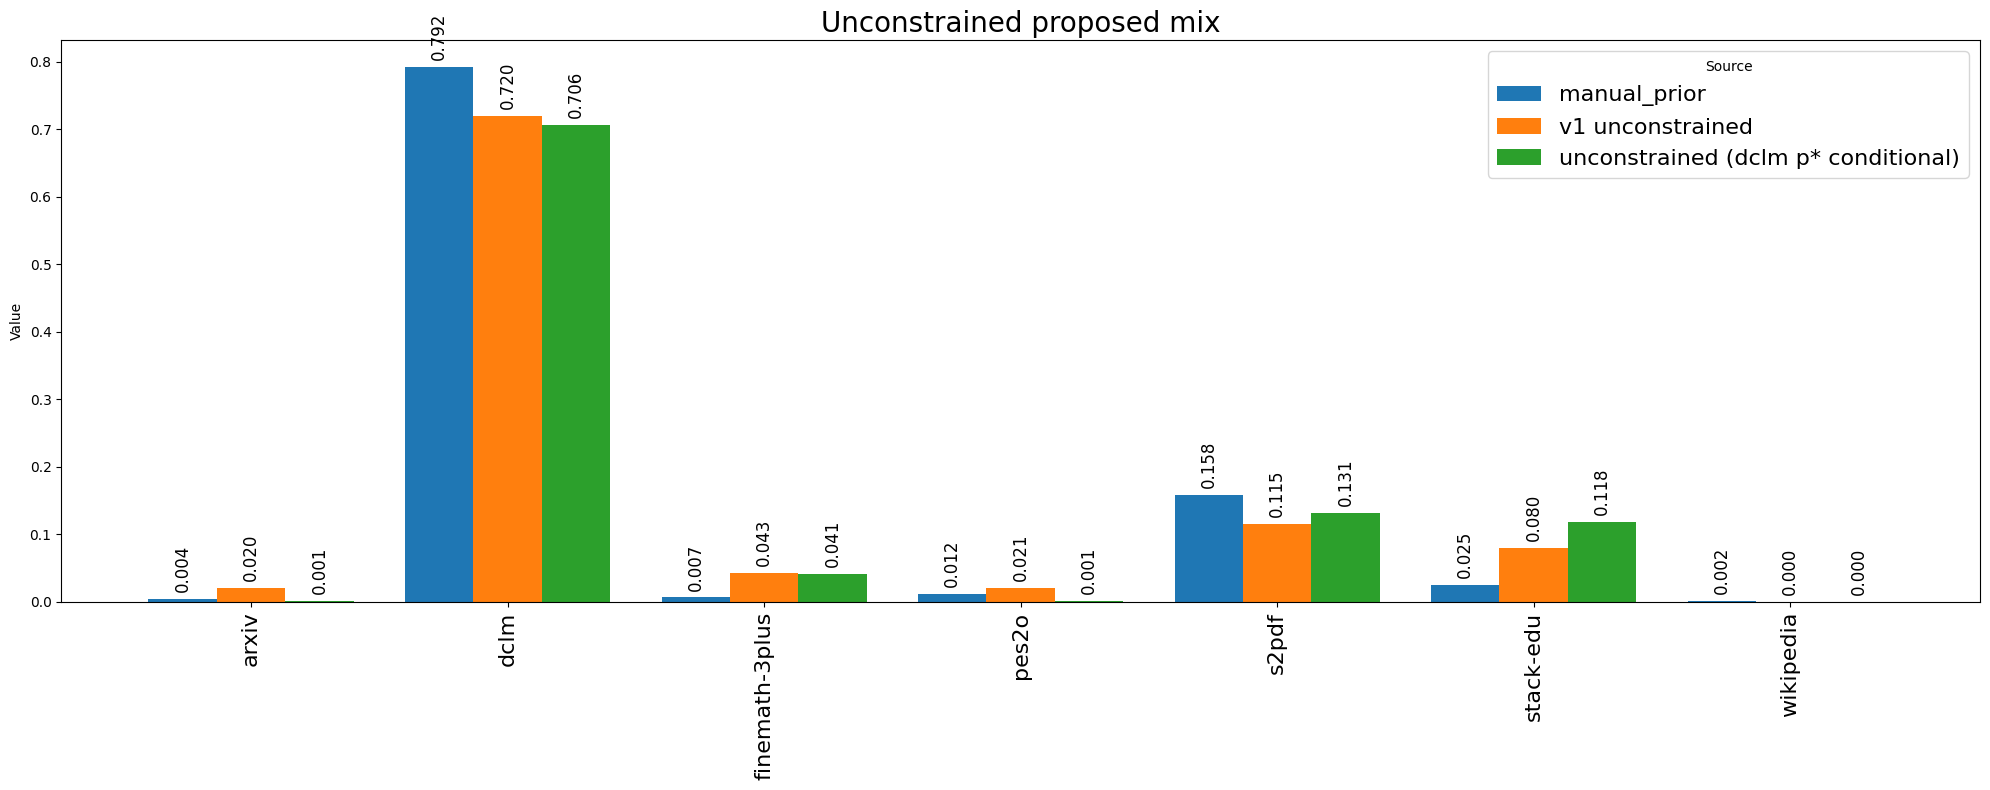

In [10]:
import matplotlib.pyplot as plt
import numpy as np

rep_source_mixes = {}

rep_source_mixes.update({"manual_prior": launch_config.manual_prior, "v1 unconstrained": v1_mix_unconstrained, "unconstrained (dclm p* conditional)": source_mix_unconstrained})



# Step 2: Collect all unique keys
all_keys = sorted(set().union(*[d.keys() for d in rep_source_mixes.values()]))

# Step 3: Extract values for each dict, aligning with `all_keys`
values_matrix = [
    [d.get(k, 0) for k in all_keys]
    for d in rep_source_mixes.values()
]

# Step 4: Plot grouped bars with annotations
n_dicts = len(rep_source_mixes)
x = np.arange(len(all_keys))
bar_width = 0.8 / n_dicts

fig, ax = plt.subplots(figsize=(20, 8))

for i, (label, values) in enumerate(zip(rep_source_mixes.keys(), values_matrix)):
    offset = (i - (n_dicts - 1) / 2) * bar_width
    bars = ax.bar(x + offset, values, width=bar_width, label=label)

    # Annotate each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height+0.01,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=12,
            rotation=90
        )

# Step 5: Format the plot
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
ax.set_ylabel("Value")
ax.set_title("Unconstrained proposed mix", fontsize=20)
ax.legend(title="Source", fontsize=16)
plt.tight_layout()
plt.show()



In [14]:
def get_topic_mix(topic, mix):
    topic_weights = {k: v for k, v in mix.items() if k.startswith(topic + ":")}
    total_weight = sum(topic_weights.values())
    normalized_weights = {k: v / total_weight for k, v in topic_weights.items()}

    return normalized_weights

In [15]:
unconstrained_mix_dclm = get_topic_mix("dclm", unconstrained_mix)

v1_mix_dclm = get_topic_mix("dclm", v1_mix)

dclm_natural = {k: v for k,v in old_priors[0].items() if k.startswith("dclm:")}
total = sum(dclm_natural.values())
dclm_natural = {k: v / total for k, v in dclm_natural.items()}

NameError: name 'old_priors' is not defined

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define your dictionaries (you can add as many as you want)
rep_pdf_mixes = {} #dict(sorted(rep_pdf_mixes.items()))
rep_pdf_mixes.update({"natural_prior": dclm_natural, "v1 unconstrained": v1_mix_dclm, "unconstrained (dclm p* conditional)": unconstrained_mix_dclm, })

# Step 2: Collect all unique keys
all_keys = sorted(set().union(*[d.keys() for d in rep_pdf_mixes.values()]))

# Step 3: Extract values for each dict, aligning with `all_keys`
values_matrix = [
    [d.get(k, 0) for k in all_keys]
    for d in rep_pdf_mixes.values()
]

# Step 4: Plot grouped bars with annotations
n_dicts = len(rep_pdf_mixes)
x = np.arange(len(all_keys))
bar_width = 0.8 / n_dicts

fig, ax = plt.subplots(figsize=(20, 10))

for i, (label, values) in enumerate(zip(rep_pdf_mixes.keys(), values_matrix)):
    offset = (i - (n_dicts - 1) / 2) * bar_width
    bars = ax.bar(x + offset, values, width=bar_width, label=label)

    # Annotate each bar
    """ for bar in bars:
        height = bar.get_height()+0.01
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=90
            )"""

# Step 5: Format the plot
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
ax.set_ylabel("Value")
ax.set_title("Comparison of Multiple Proposed mixes", fontsize=20)
ax.legend(title="Source", fontsize=16)
plt.tight_layout()
plt.show()


NameError: name 'dclm_natural' is not defined

In [17]:
rep_pdf_mixes = {}
for rep, mix in sweep_repetition_factor_pdf_mixes.items():
    print(f"Repetition factor: {rep}")
    mix = {f"s2pdf:{k}" : v for k, v in mix.items()}
    rep_pdf_mixes[rep] = mix

unconstrained_mix_pdf = get_topic_mix("s2pdf", unconstrained_mix)

v1_mix_pdf = get_topic_mix("s2pdf", v1_mix)


pdf_only = "output/8b10a86d_6d2d4c39/basic_proposed_mix/9e8e975817b2db18/pdf_tasks_log_linear_reg_1_samples_optimal.json"
with open(pdf_only, "r") as f:
    pdf_only = json.load(f)
pdf_only = {'s2pdf:' + m['domain']: m['weight'] for m in pdf_only}



pdf_natural = {k: v for k,v in priors[0].items() if k.startswith("s2pdf:")}
total = sum(pdf_natural.values())
pdf_natural = {k: v / total for k, v in pdf_natural.items()}

Repetition factor: 2.0
Repetition factor: 4.0
Repetition factor: 3.0
Repetition factor: 5.0


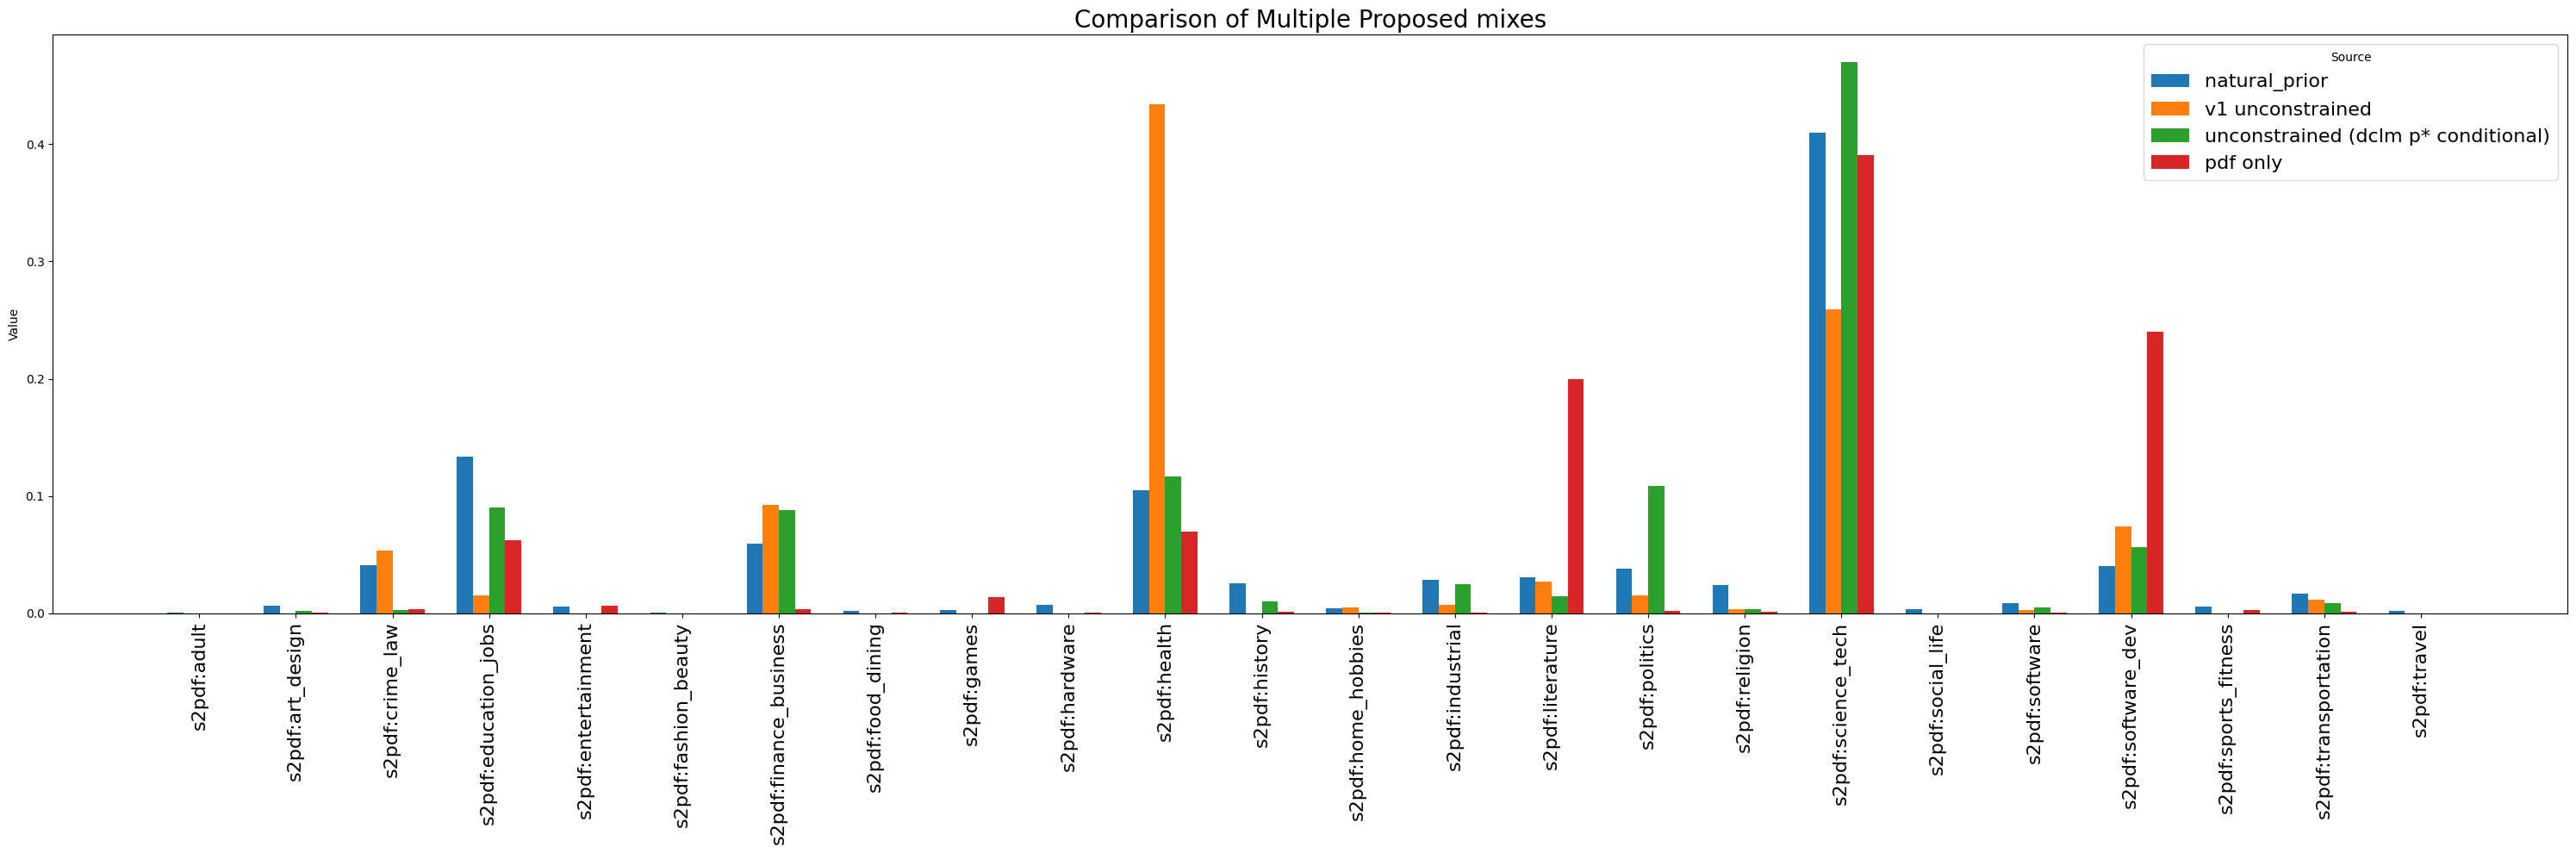

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define your dictionaries (you can add as many as you want)
rep_pdf_mixes = {} #dict(sorted(rep_pdf_mixes.items()))
rep_pdf_mixes.update({"natural_prior": pdf_natural, "v1 unconstrained": v1_mix_pdf, "unconstrained (dclm p* conditional)": unconstrained_mix_pdf,  "pdf only": pdf_only})

# Step 2: Collect all unique keys
all_keys = sorted(set().union(*[d.keys() for d in rep_pdf_mixes.values()]))

# Step 3: Extract values for each dict, aligning with `all_keys`
values_matrix = [
    [d.get(k, 0) for k in all_keys]
    for d in rep_pdf_mixes.values()
]

# Step 4: Plot grouped bars with annotations
# Step 4: Plot grouped bars with annotations
n_dicts = len(rep_pdf_mixes)
group_spacing = 1.5  # Spread out the bar groups (1.0 = default spacing)
x = np.arange(len(all_keys)) * group_spacing
bar_width = 1 / n_dicts  # Increased for thicker bars

fig, ax = plt.subplots(figsize=(30, 10))

for i, (label, values) in enumerate(zip(rep_pdf_mixes.keys(), values_matrix)):
    offset = (i - (n_dicts - 1) / 2) * bar_width
    bars = ax.bar(x + offset, values, width=bar_width, label=label)


    # Annotate each bar
    """ for bar in bars:
        height = bar.get_height()+0.01
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=90
            )"""

# Step 5: Format the plot
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
ax.set_ylabel("Value")
ax.set_title("Comparison of Multiple Proposed mixes", fontsize=20)
ax.legend(title="Source", fontsize=16)
plt.tight_layout()
plt.show()


In [19]:
"""rep_stack_mixes = {}
for rep, mix in sweep_repetition_factor_mixes.items():
    print(f"Repetition factor: {rep}")
    topic_mix = get_topic_mix("stack-edu", mix)
    rep_stack_mixes[rep] = topic_mix"""

unconstrained_mix_stack = get_topic_mix("stack-edu", unconstrained_mix)
v1_mix_stack = get_topic_mix("stack-edu", v1_mix)



stack_only = "output/e250076d_a0e3840c/basic_proposed_mix/c42b4ab575f9fe7e/code_tasks_log_linear_reg_1_samples_optimal.json"
with open(stack_only, "r") as f:
    stack_only = json.load(f)
stack_only = {'stack-edu:' + m['domain']: m['weight'] for m in stack_only}

stack_natural = {k: v for k,v in priors[0].items() if k.startswith("stack-edu:")}
total = sum(stack_natural.values())
stack_natural = {k: v / total for k, v in stack_natural.items()}

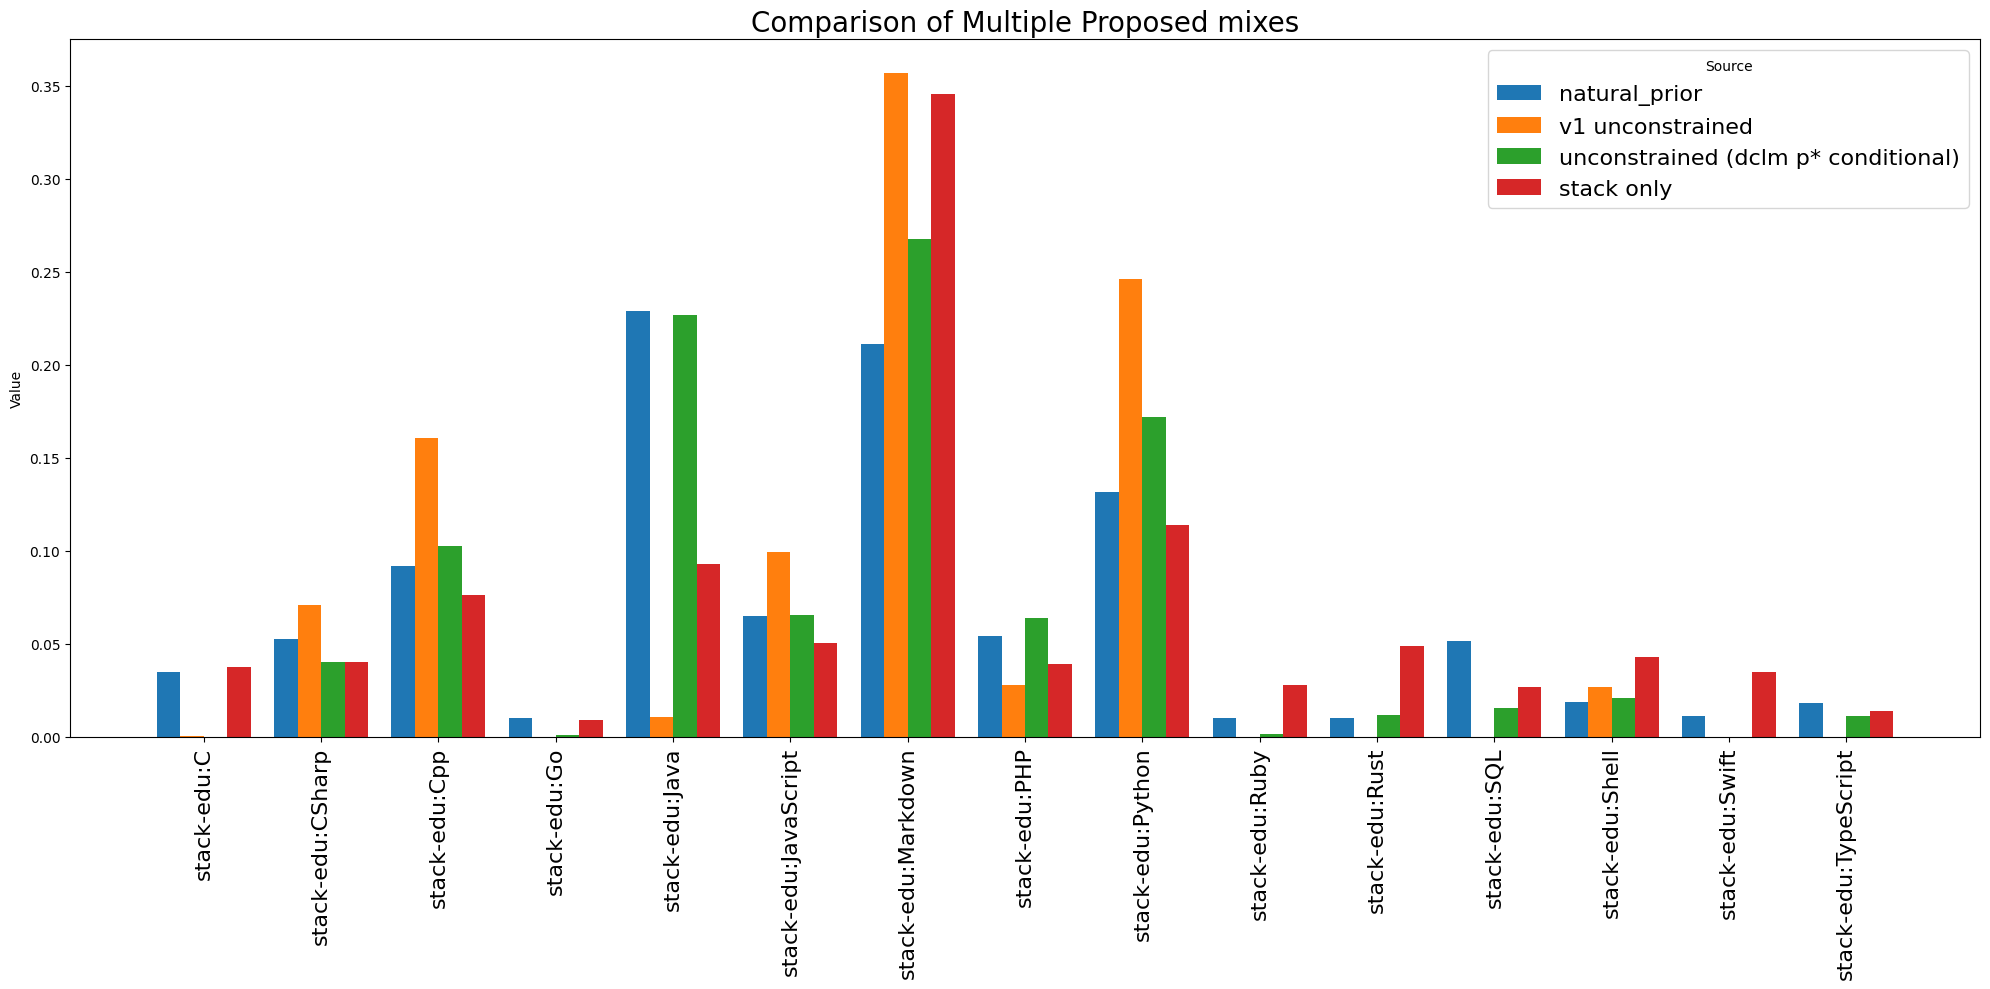

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define your dictionaries (you can add as many as you want)
rep_stack_mixes = {}# dict(sorted(rep_stack_mixes.items()))
rep_stack_mixes.update({"natural_prior": stack_natural, "v1 unconstrained": v1_mix_stack,  "unconstrained (dclm p* conditional)": unconstrained_mix_stack, 'stack only': stack_only})    

# Step 2: Collect all unique keys
all_keys = sorted(set().union(*[d.keys() for d in rep_stack_mixes.values()]))

# Step 3: Extract values for each dict, aligning with `all_keys`
values_matrix = [
    [d.get(k, 0) for k in all_keys]
    for d in rep_stack_mixes.values()
]

# Step 4: Plot grouped bars with annotations
n_dicts = len(rep_stack_mixes)
x = np.arange(len(all_keys))
bar_width = 0.8 / n_dicts

fig, ax = plt.subplots(figsize=(20, 10))

for i, (label, values) in enumerate(zip(rep_stack_mixes.keys(), values_matrix)):
    offset = (i - (n_dicts - 1) / 2) * bar_width
    bars = ax.bar(x + offset, values, width=bar_width, label=label)

    # Annotate each bar
    """ for bar in bars:
        height = bar.get_height()+0.01
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=90
            )"""

# Step 5: Format the plot
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
ax.set_ylabel("Value")
ax.set_title("Comparison of Multiple Proposed mixes", fontsize=20)
ax.legend(title="Source", fontsize=16)
plt.tight_layout()
plt.show()


In [21]:
"""rep_stack_mixes = {}
for rep, mix in sweep_repetition_factor_mixes.items():
    print(f"Repetition factor: {rep}")
    topic_mix = get_topic_mix("stack-edu", mix)
    rep_stack_mixes[rep] = topic_mix"""

unconstrained_mix_stack = get_topic_mix("pes2o", unconstrained_mix)

stack_natural = {k: v for k,v in priors[0].items() if k.startswith("pes2o:")}
total = sum(stack_natural.values())
stack_natural = {k: v / total for k, v in stack_natural.items()}

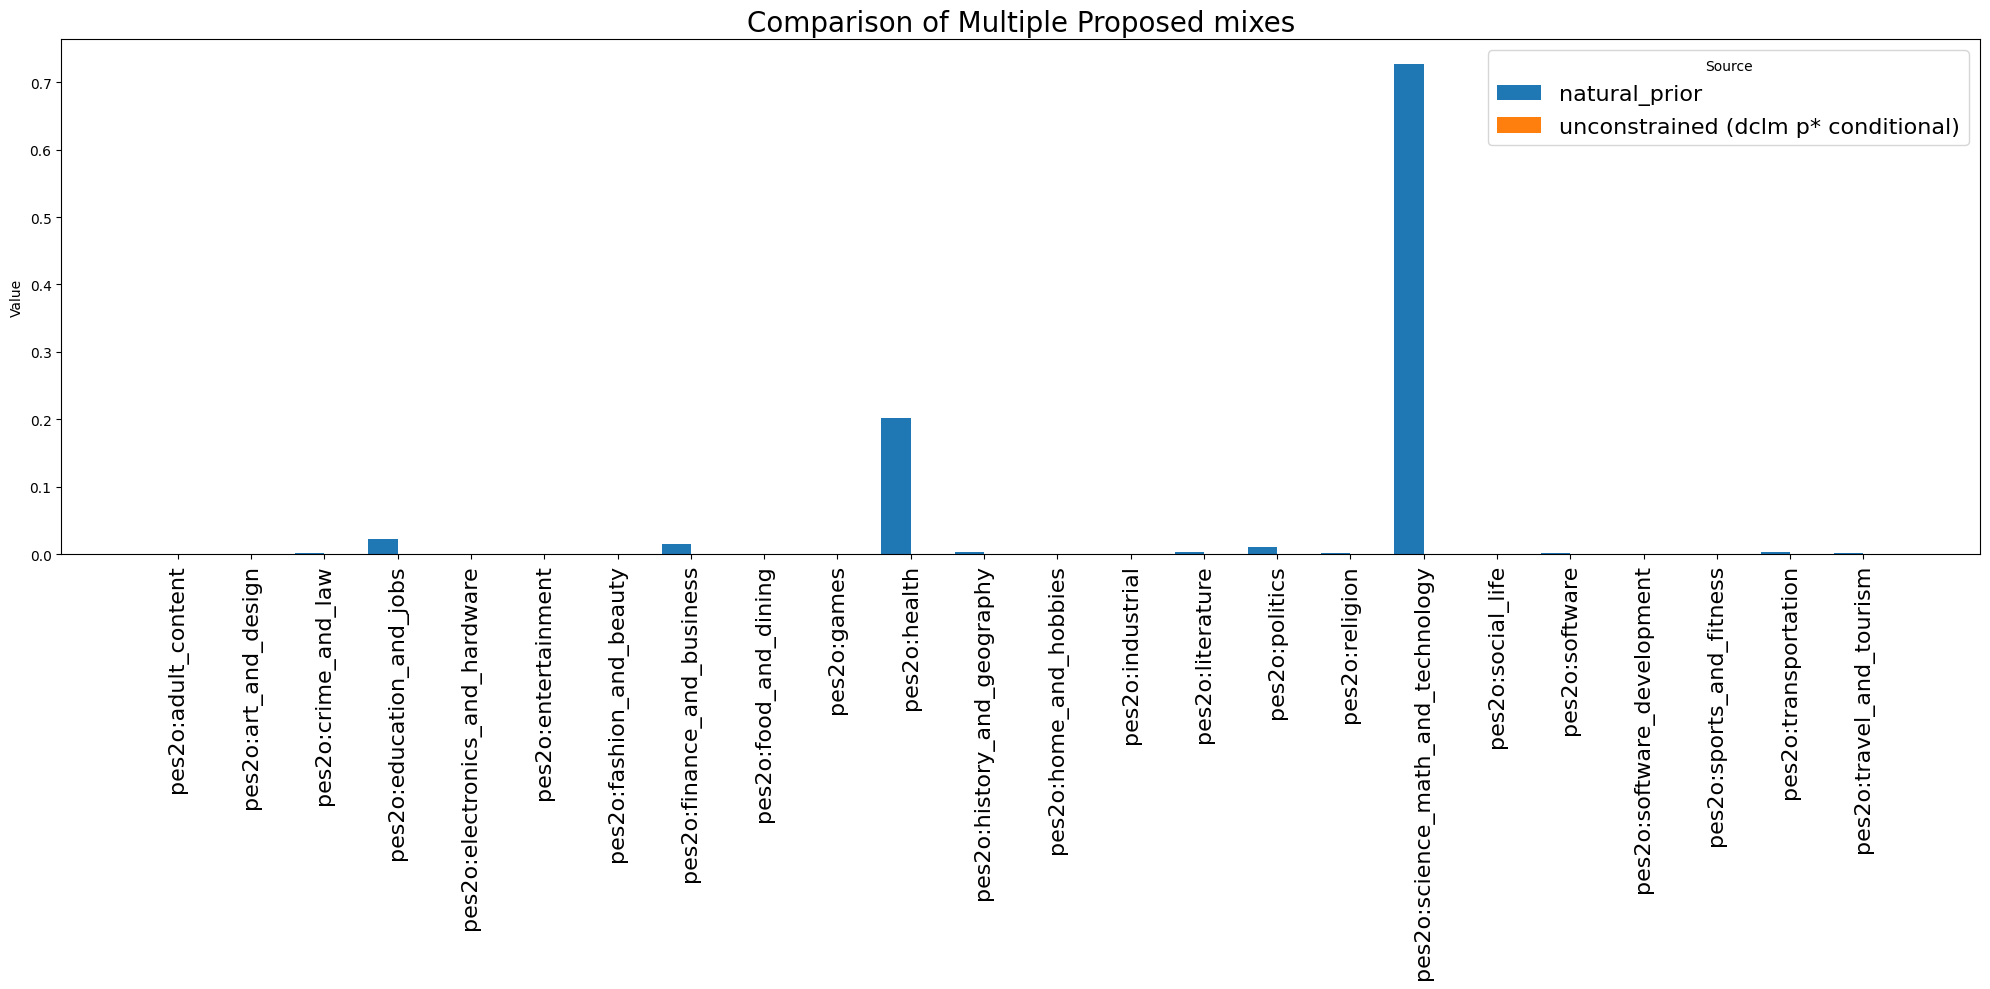

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define your dictionaries (you can add as many as you want)
rep_stack_mixes = {}# dict(sorted(rep_stack_mixes.items()))
rep_stack_mixes.update({"natural_prior": stack_natural, "unconstrained (dclm p* conditional)": unconstrained_mix_stack})    

# Step 2: Collect all unique keys
all_keys = sorted(set().union(*[d.keys() for d in rep_stack_mixes.values()]))

# Step 3: Extract values for each dict, aligning with `all_keys`
values_matrix = [
    [d.get(k, 0) for k in all_keys]
    for d in rep_stack_mixes.values()
]

# Step 4: Plot grouped bars with annotations
n_dicts = len(rep_stack_mixes)
x = np.arange(len(all_keys))
bar_width = 0.8 / n_dicts

fig, ax = plt.subplots(figsize=(20, 10))

for i, (label, values) in enumerate(zip(rep_stack_mixes.keys(), values_matrix)):
    offset = (i - (n_dicts - 1) / 2) * bar_width
    bars = ax.bar(x + offset, values, width=bar_width, label=label)

    # Annotate each bar
    """ for bar in bars:
        height = bar.get_height()+0.01
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=90
            )"""

# Step 5: Format the plot
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
ax.set_ylabel("Value")
ax.set_title("Comparison of Multiple Proposed mixes", fontsize=20)
ax.legend(title="Source", fontsize=16)
plt.tight_layout()
plt.show()


## Second, examine proposed mixes with repetition constraints

In [11]:
folder = "output/4252db91/sweep_repetition_factor"
folder = "output/84313ca4/fixed_sweep_repetition_factor"
runs = os.listdir(folder)


sweep_repetition_factor_v2 = {}
for run in runs:
    config_path = os.path.join(folder, run, "config.json")
    mix_path = os.path.join(folder, run, "olmo3_offline_tasks_log_linear_reg_1_samples_optimal.json")

    with open(config_path, "r") as f:   
        config = json.load(f)

    if 'repetition_factor' in config:
        repetition_factor = config['repetition_factor']
    else:
        repetition_factor = 1

    if repetition_factor == 1:
        continue


    print(mix_path, repetition_factor)

    with open(mix_path, "r") as f:
        mix = json.load(f)

    sweep_repetition_factor_v2[str(repetition_factor)] = {m['domain']: m['weight'] for m in mix}


output/84313ca4/fixed_sweep_repetition_factor/6a378e3367e9bb04/olmo3_offline_tasks_log_linear_reg_1_samples_optimal.json 5.0
output/84313ca4/fixed_sweep_repetition_factor/dc1748f348b99a5b/olmo3_offline_tasks_log_linear_reg_1_samples_optimal.json 3.0
output/84313ca4/fixed_sweep_repetition_factor/3a28bff99c94fed7/olmo3_offline_tasks_log_linear_reg_1_samples_optimal.json 4.0


In [12]:
folder = "output/ee28fc9c/sweep_repetition_factor"
runs = os.listdir(folder)


sweep_repetition_factor_v1 = {}
for run in runs:
    config_path = os.path.join(folder, run, "config.json")
    mix_path = os.path.join(folder, run, "superswarm_offline_log_linear_reg_1_samples_optimal.json")

    with open(config_path, "r") as f:   
        config = json.load(f)

    if 'repetition_factor' in config:
        repetition_factor = config['repetition_factor']
    else:
        repetition_factor = 1

    if repetition_factor == 1:
        continue


    print(mix_path, repetition_factor)

    with open(mix_path, "r") as f:
        mix = json.load(f)

    sweep_repetition_factor_v1[str(repetition_factor)] = {m['domain']: m['weight'] for m in mix}


output/ee28fc9c/sweep_repetition_factor/476787e6c553295b/superswarm_offline_log_linear_reg_1_samples_optimal.json 3.5
output/ee28fc9c/sweep_repetition_factor/61fd0ad2a2ec8916/superswarm_offline_log_linear_reg_1_samples_optimal.json 1.5
output/ee28fc9c/sweep_repetition_factor/15daeed9589af171/superswarm_offline_log_linear_reg_1_samples_optimal.json 5.0
output/ee28fc9c/sweep_repetition_factor/c013e78528c3920a/superswarm_offline_log_linear_reg_1_samples_optimal.json 4.0
output/ee28fc9c/sweep_repetition_factor/f4a42973d8949a24/superswarm_offline_log_linear_reg_1_samples_optimal.json 4.5
output/ee28fc9c/sweep_repetition_factor/d09c385f3ad36c77/superswarm_offline_log_linear_reg_1_samples_optimal.json 2.5
output/ee28fc9c/sweep_repetition_factor/51b45b6d88a3ef98/superswarm_offline_log_linear_reg_1_samples_optimal.json 6.0
output/ee28fc9c/sweep_repetition_factor/1ef0b3a3fe74aa33/superswarm_offline_log_linear_reg_1_samples_optimal.json 2.0
output/ee28fc9c/sweep_repetition_factor/4331f88171faa53c

In [13]:
folder = "output/ee28fc9c/sweep_repetition_factor/"
folder = "output/8b10a86d_6d2d4c39/sweep_repetition_factor"
runs = os.listdir(folder)


sweep_repetition_factor_pdf_mixes = {}
for run in runs:
    config_path = os.path.join(folder, run, "config.json")
    mix_path = os.path.join(folder, run, "pdf_tasks_log_linear_reg_1_samples_optimal.json")

    with open(config_path, "r") as f:   
        config = json.load(f)

    if 'repetition_factor' in config:
        repetition_factor = config['repetition_factor']
    else:
        repetition_factor = 1

    if repetition_factor == 1:
        continue


    print(mix_path, repetition_factor)

    with open(mix_path, "r") as f:
        mix = json.load(f)

    sweep_repetition_factor_pdf_mixes[str(repetition_factor)] = {m['domain']: m['weight'] for m in mix}


output/8b10a86d_6d2d4c39/sweep_repetition_factor/9b9c8c0a75758cee/pdf_tasks_log_linear_reg_1_samples_optimal.json 2.0
output/8b10a86d_6d2d4c39/sweep_repetition_factor/d837407f116a7cc2/pdf_tasks_log_linear_reg_1_samples_optimal.json 4.0
output/8b10a86d_6d2d4c39/sweep_repetition_factor/97fe4f0bc6975cce/pdf_tasks_log_linear_reg_1_samples_optimal.json 3.0
output/8b10a86d_6d2d4c39/sweep_repetition_factor/97683034cb61af86/pdf_tasks_log_linear_reg_1_samples_optimal.json 5.0


In [14]:
folder = "output/e250076d_a0e3840c/sweep_repetition_factor"
runs = os.listdir(folder)


sweep_repetition_factor_stack_mixes = {}
for run in runs:
    config_path = os.path.join(folder, run, "config.json")
    mix_path = os.path.join(folder, run, "code_tasks_log_linear_reg_1_samples_optimal.json")

    with open(config_path, "r") as f:   
        config = json.load(f)

    if 'repetition_factor' in config:
        repetition_factor = config['repetition_factor']
    else:
        repetition_factor = 1

    if repetition_factor == 1:
        continue


    print(mix_path, repetition_factor)

    with open(mix_path, "r") as f:
        mix = json.load(f)

    sweep_repetition_factor_stack_mixes[str(repetition_factor)] = {m['domain']: m['weight'] for m in mix}


output/e250076d_a0e3840c/sweep_repetition_factor/d2acbb3afcbcbe6d/code_tasks_log_linear_reg_1_samples_optimal.json 2.0
output/e250076d_a0e3840c/sweep_repetition_factor/510ee3b1e68cd3d8/code_tasks_log_linear_reg_1_samples_optimal.json 3.0
output/e250076d_a0e3840c/sweep_repetition_factor/ff3fcebf8af92a23/code_tasks_log_linear_reg_1_samples_optimal.json 4.0
output/e250076d_a0e3840c/sweep_repetition_factor/d742f88256c6bb88/code_tasks_log_linear_reg_1_samples_optimal.json 5.0


In [15]:
def get_source_mix(mix):
    source_level = defaultdict(float)
    for source, weight in mix.items():
        if source.startswith("dclm:"):
            source_level["dclm"] += weight
        elif source.startswith("s2pdf:"):
            source_level["s2pdf"] += weight
        elif source.startswith("stack-edu:"):
            source_level["stack-edu"] += weight
        elif source.startswith("pes2o:"):
            source_level["pes2o"] += weight
        else:
            source_level[source] += weight
    return source_level


In [16]:
rep_source_mixes = {}
for rep, mix in sweep_repetition_factor_v1.items():
    print(f"Repetition factor: {rep}")
    if rep in ["1.5", "2.5", "3.5", "4.5"]:
        continue
    source_mix = get_source_mix(mix)
    rep_source_mixes[f"v1 {rep}"] = source_mix

Repetition factor: 3.5
Repetition factor: 1.5
Repetition factor: 5.0
Repetition factor: 4.0
Repetition factor: 4.5
Repetition factor: 2.5
Repetition factor: 6.0
Repetition factor: 2.0
Repetition factor: 3.0


In [17]:
for rep, mix in sweep_repetition_factor_v2.items():
    print(f"Repetition factor: {rep}")
    source_mix = get_source_mix(mix)
    rep_source_mixes[f"v2 {rep}"] = source_mix

Repetition factor: 5.0
Repetition factor: 3.0
Repetition factor: 4.0


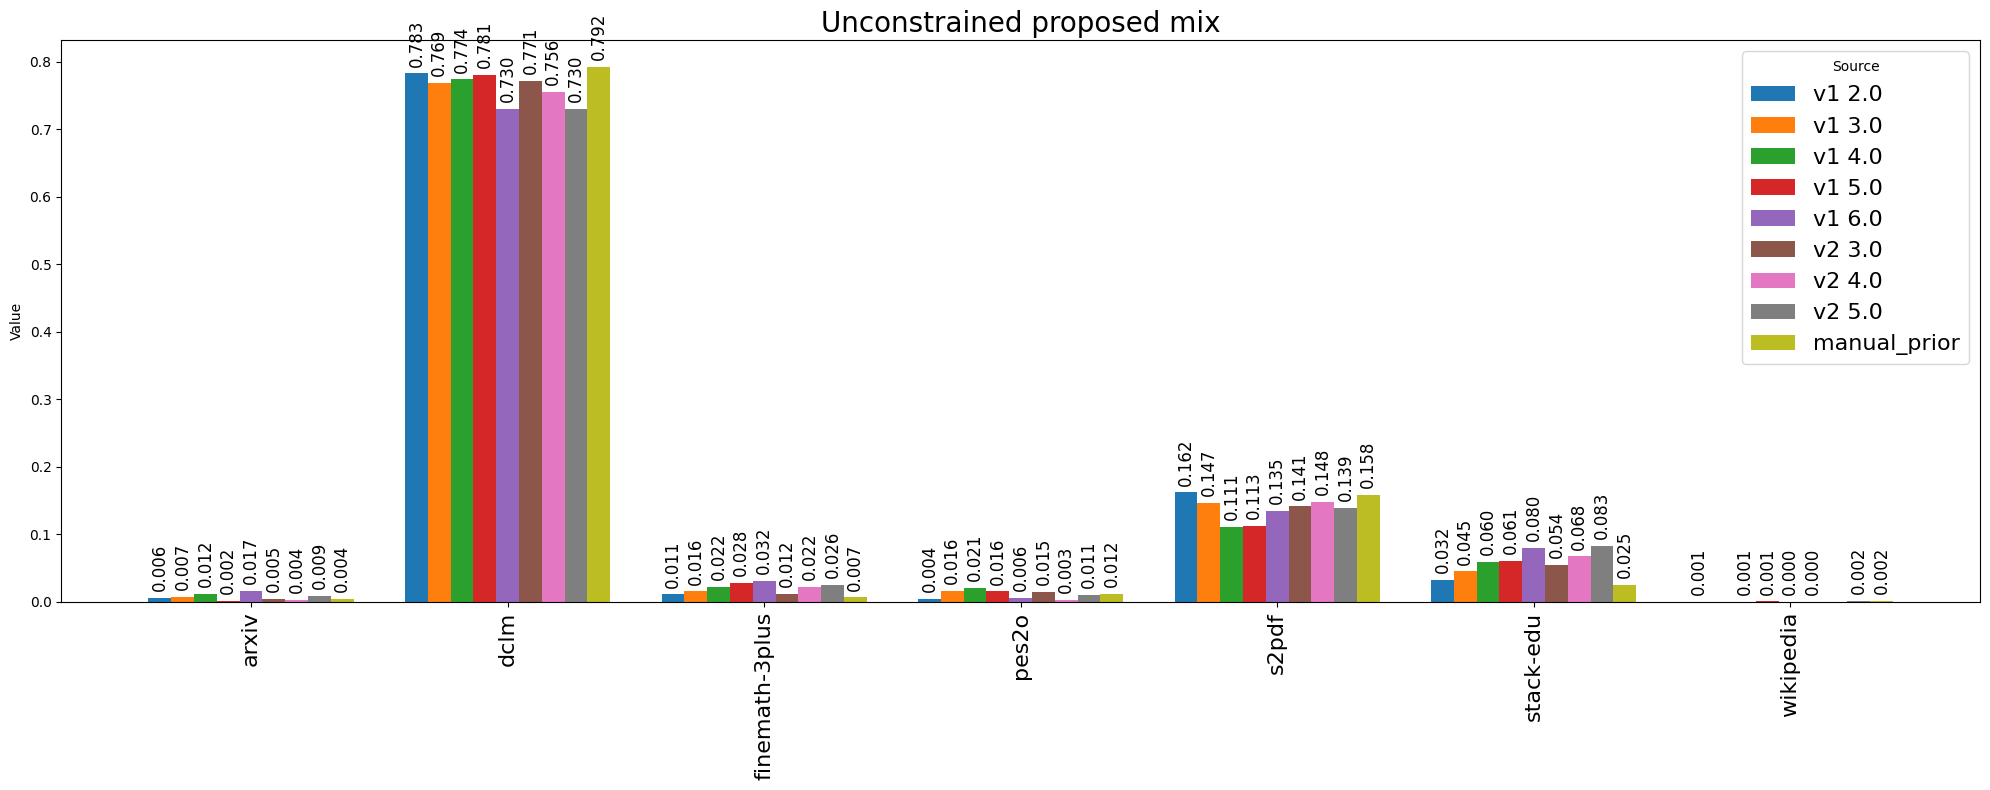

In [18]:
import matplotlib.pyplot as plt
import numpy as np


rep_source_mixes = dict(sorted(rep_source_mixes.items()))
rep_source_mixes.update({"manual_prior": launch_config.manual_prior})



# Step 2: Collect all unique keys
all_keys = sorted(set().union(*[d.keys() for d in rep_source_mixes.values()]))

# Step 3: Extract values for each dict, aligning with `all_keys`
values_matrix = [
    [d.get(k, 0) for k in all_keys]
    for d in rep_source_mixes.values()
]

# Step 4: Plot grouped bars with annotations
n_dicts = len(rep_source_mixes)
x = np.arange(len(all_keys))
bar_width = 0.8 / n_dicts

fig, ax = plt.subplots(figsize=(20, 8))

for i, (label, values) in enumerate(zip(rep_source_mixes.keys(), values_matrix)):
    offset = (i - (n_dicts - 1) / 2) * bar_width
    bars = ax.bar(x + offset, values, width=bar_width, label=label)

    # Annotate each bar
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,               # use this only for vertical position
                f"{height:.3f}",             # display the correct value
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=90
            )


# Step 5: Format the plot
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
ax.set_ylabel("Value")
ax.set_title("Unconstrained proposed mix", fontsize=20)
ax.legend(title="Source", fontsize=16)
plt.tight_layout()
plt.show()



In [31]:
def get_topic_mix(topic, mix):
    topic_weights = {k: v for k, v in mix.items() if k.startswith(topic + ":")}
    total_weight = sum(topic_weights.values())
    normalized_weights = {k: v / total_weight for k, v in topic_weights.items()}

    return normalized_weights

In [32]:
rep_dclm_mixes = {}
for rep, mix in sweep_repetition_factor_v1.items():
    print(f"Repetition factor: {rep}")
    if rep in ["1.5", "2.5", "3.5", "4.5"]:
        continue
    topic_mix = get_topic_mix("dclm", mix)
    rep_dclm_mixes[f"{rep} v1"] = topic_mix

for rep, mix in sweep_repetition_factor_v2.items():
    print(f"Repetition factor: {rep}")

    topic_mix = get_topic_mix("dclm", mix)
    rep_dclm_mixes[f"fixed p* for v2"] = topic_mix
    break 

dclm_natural = {k: v for k,v in priors[0].items() if k.startswith("dclm:")}
total = sum(dclm_natural.values())
dclm_natural = {k: v / total for k, v in dclm_natural.items()}

Repetition factor: 3.5
Repetition factor: 1.5
Repetition factor: 5.0
Repetition factor: 4.0
Repetition factor: 4.5
Repetition factor: 2.5
Repetition factor: 6.0
Repetition factor: 2.0
Repetition factor: 3.0
Repetition factor: 5.0


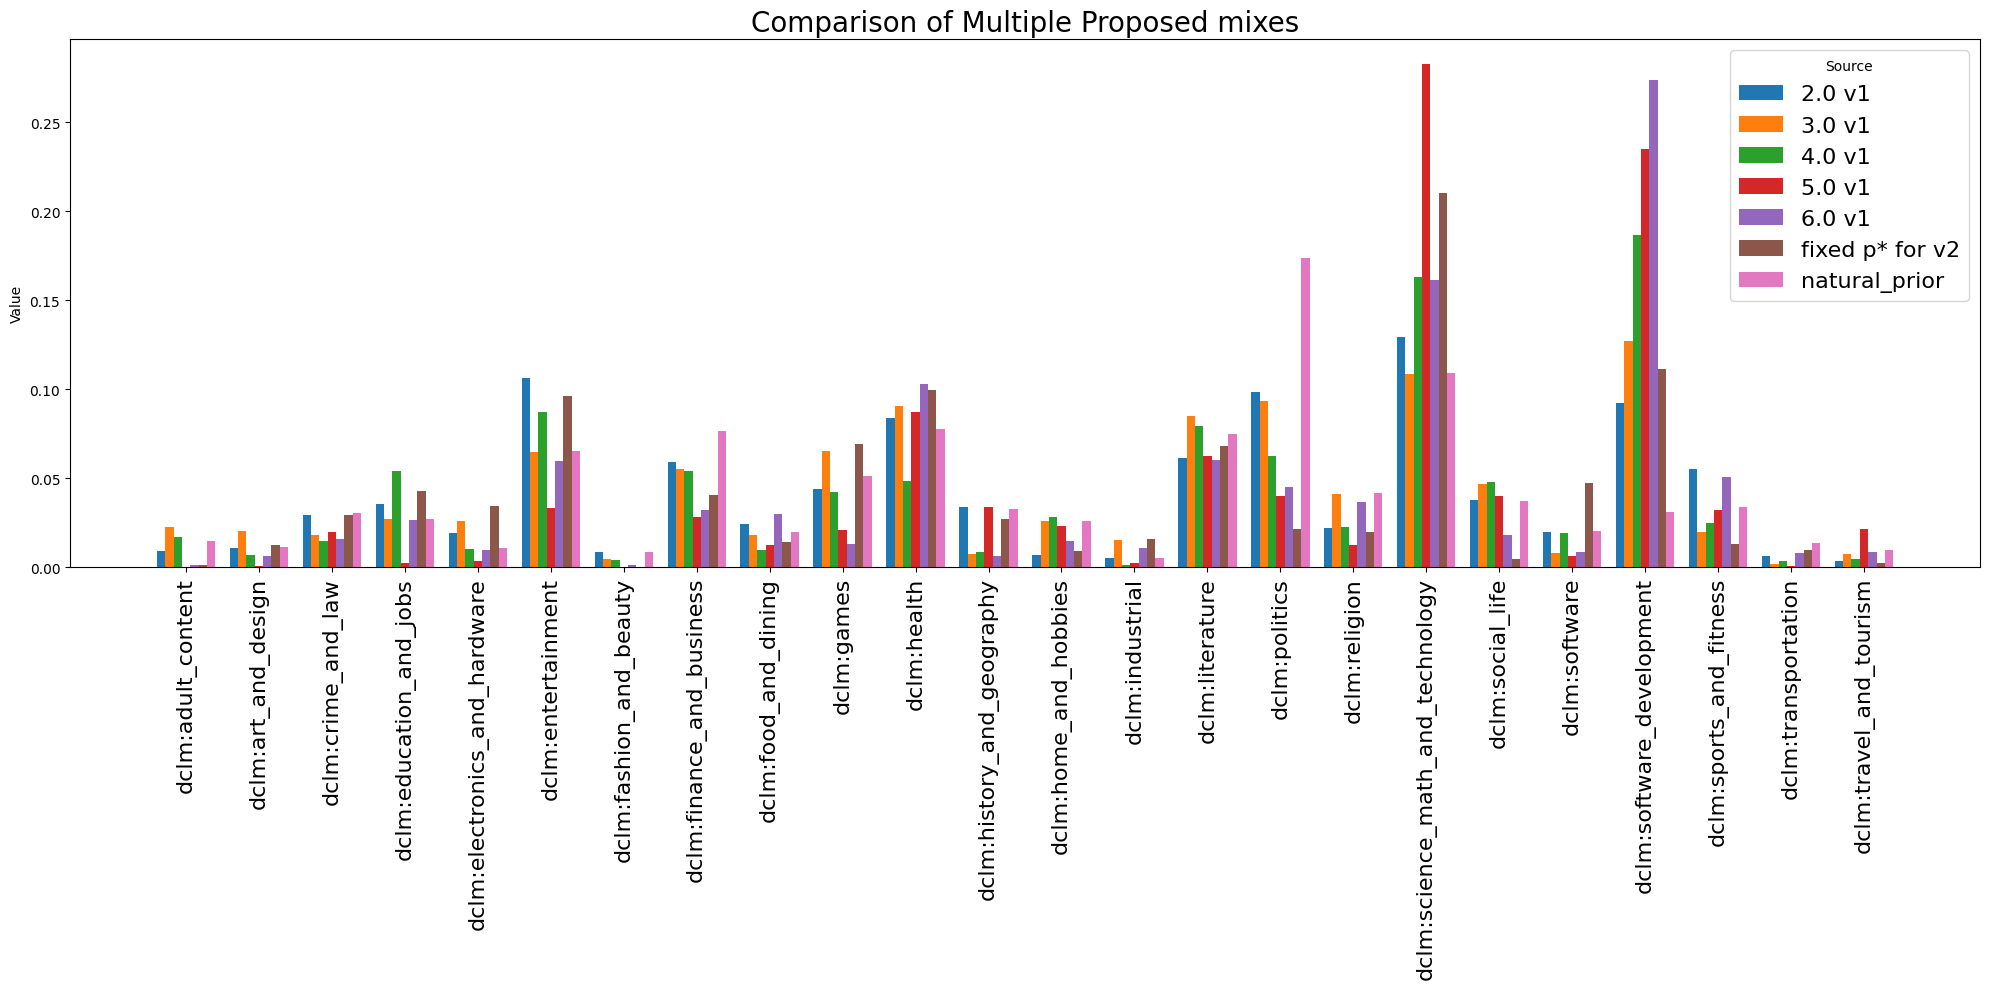

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define your dictionaries (you can add as many as you want)
rep_dclm_mixes = dict(sorted(rep_dclm_mixes.items()))
rep_dclm_mixes.update({"natural_prior": dclm_natural})

# Step 2: Collect all unique keys
all_keys = sorted(set().union(*[d.keys() for d in rep_dclm_mixes.values()]))

# Step 3: Extract values for each dict, aligning with `all_keys`
values_matrix = [
    [d.get(k, 0) for k in all_keys]
    for d in rep_dclm_mixes.values()
]

# Step 4: Plot grouped bars with annotations
n_dicts = len(rep_dclm_mixes)
x = np.arange(len(all_keys))
bar_width = 0.8 / n_dicts

fig, ax = plt.subplots(figsize=(20, 10))

for i, (label, values) in enumerate(zip(rep_dclm_mixes.keys(), values_matrix)):
    offset = (i - (n_dicts - 1) / 2) * bar_width
    bars = ax.bar(x + offset, values, width=bar_width, label=label)

    # Annotate each bar
    """ for bar in bars:
        height = bar.get_height()+0.01
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=90
            )"""

# Step 5: Format the plot
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
ax.set_ylabel("Value")
ax.set_title("Comparison of Multiple Proposed mixes", fontsize=20)
ax.legend(title="Source", fontsize=16)
plt.tight_layout()
plt.show()


In [34]:
rep_pdf_mixes = {}
#for rep, mix in sweep_repetition_factor_pdf_mixes.items():
#    print(f"Repetition factor: {rep}")
#    mix = {f"s2pdf:{k}" : v for k, v in mix.items()}
#    rep_pdf_mixes[rep] = mix


for rep, mix in sweep_repetition_factor_v2.items():
    print(f"Repetition factor: {rep}")
    if rep in ["1.5", "2.5", "3.5", "4.5"]:
        continue

    mix = get_topic_mix("s2pdf", mix)
    rep_pdf_mixes[f"v2 {rep}"] = mix

for rep, mix in sweep_repetition_factor_v1.items():
    print(f"Repetition factor: {rep}")
    mix = get_topic_mix("s2pdf", mix)
    if rep in ["1.5", "2.5", "3.5", "4.5"]:
        continue
    rep_pdf_mixes[f"v1 {rep}"] = mix



pdf_natural = {k: v for k,v in priors[0].items() if k.startswith("s2pdf:")}
total = sum(pdf_natural.values())
pdf_natural = {k: v / total for k, v in pdf_natural.items()}

Repetition factor: 5.0
Repetition factor: 3.0
Repetition factor: 4.0
Repetition factor: 3.5
Repetition factor: 1.5
Repetition factor: 5.0
Repetition factor: 4.0
Repetition factor: 4.5
Repetition factor: 2.5
Repetition factor: 6.0
Repetition factor: 2.0
Repetition factor: 3.0


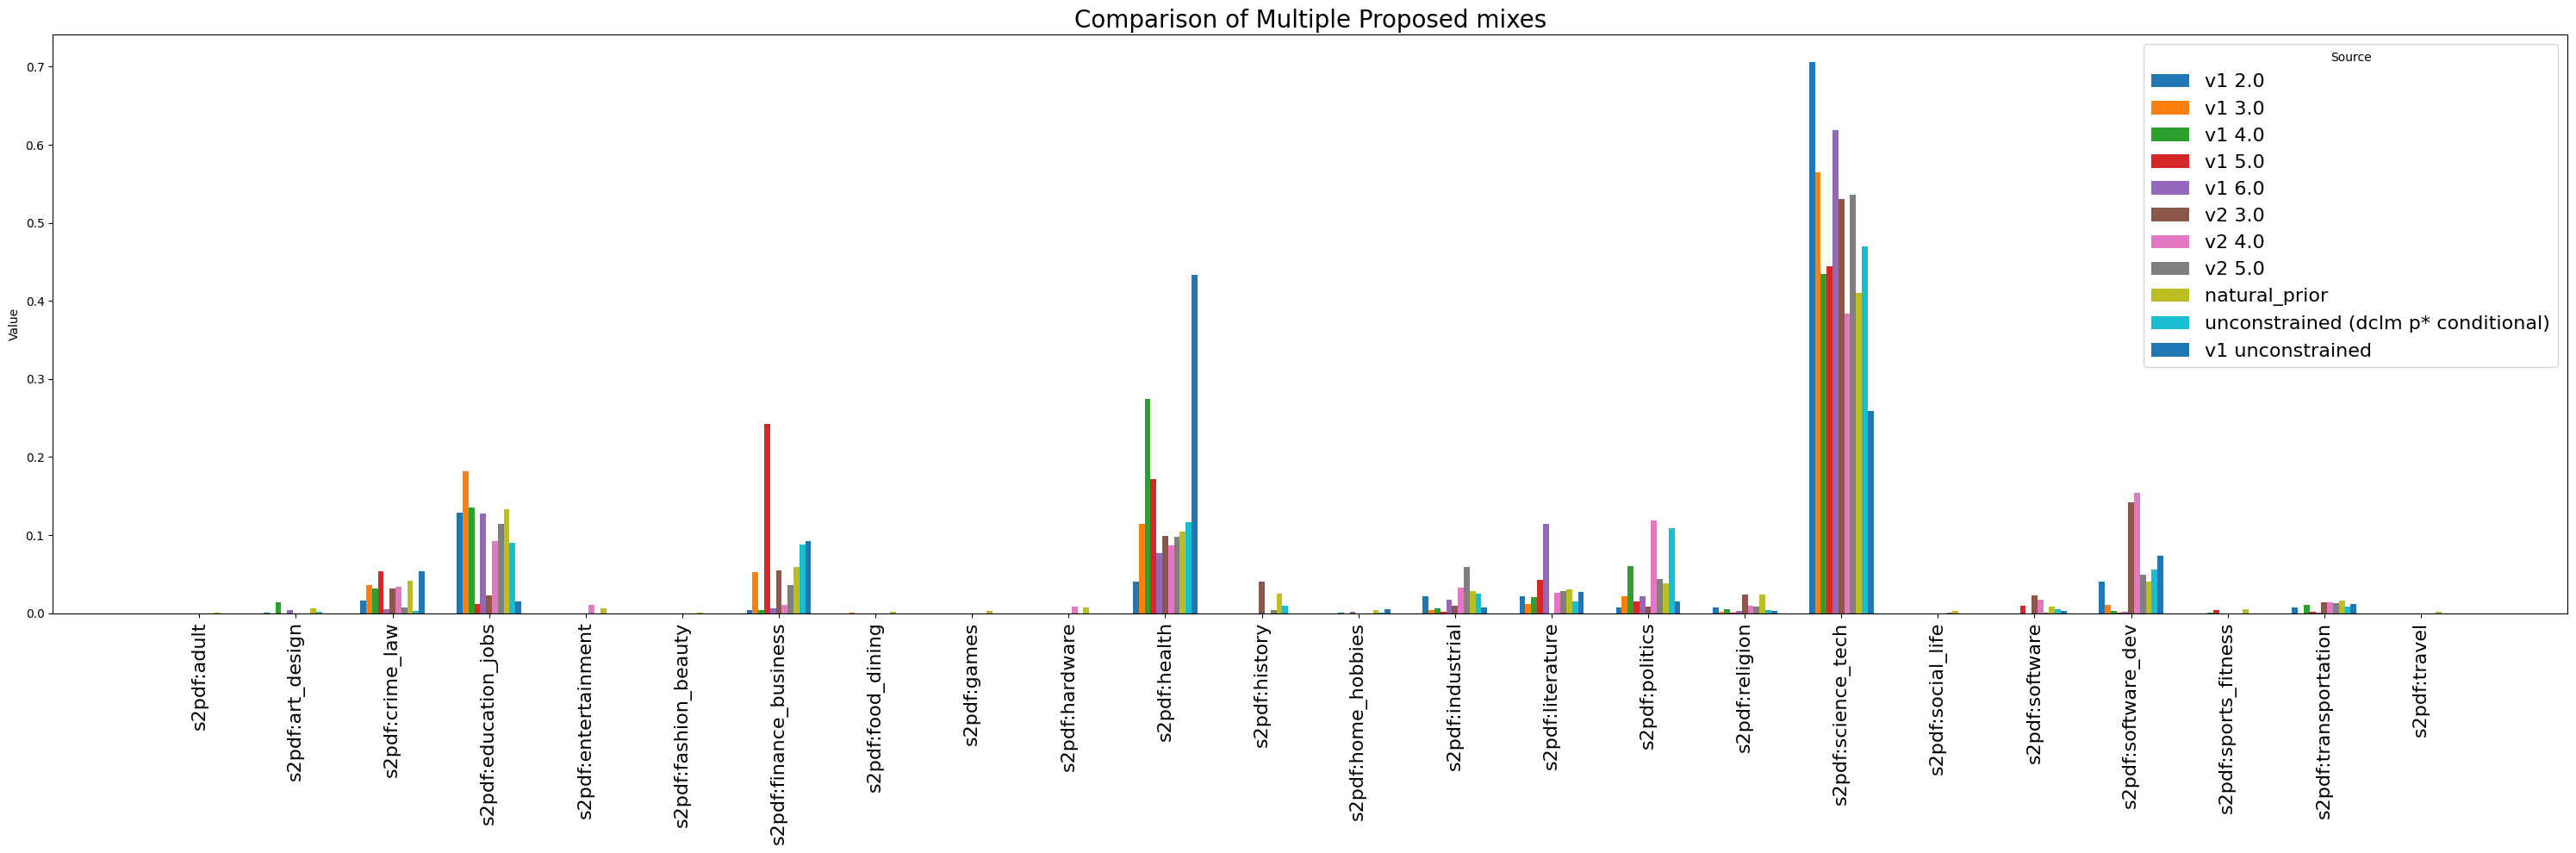

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define your dictionaries (you can add as many as you want)
rep_pdf_mixes = dict(sorted(rep_pdf_mixes.items()))
rep_pdf_mixes.update({"natural_prior": pdf_natural, "unconstrained (dclm p* conditional)": unconstrained_mix_pdf, "v1 unconstrained": v1_mix_pdf})

# Step 2: Collect all unique keys
all_keys = sorted(set().union(*[d.keys() for d in rep_pdf_mixes.values()]))

# Step 3: Extract values for each dict, aligning with `all_keys`
values_matrix = [
    [d.get(k, 0) for k in all_keys]
    for d in rep_pdf_mixes.values()
]

# Step 4: Plot grouped bars with annotations
# Step 4: Plot grouped bars with annotations
n_dicts = len(rep_pdf_mixes)
group_spacing = 1.5  # Spread out the bar groups (1.0 = default spacing)
x = np.arange(len(all_keys)) * group_spacing
bar_width = 1 / n_dicts  # Increased for thicker bars

fig, ax = plt.subplots(figsize=(30, 10))

for i, (label, values) in enumerate(zip(rep_pdf_mixes.keys(), values_matrix)):
    offset = (i - (n_dicts - 1) / 2) * bar_width
    bars = ax.bar(x + offset, values, width=bar_width, label=label)


    # Annotate each bar
    """ for bar in bars:
        height = bar.get_height()+0.01
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=90
            )"""

# Step 5: Format the plot
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
ax.set_ylabel("Value")
ax.set_title("Comparison of Multiple Proposed mixes", fontsize=20)
ax.legend(title="Source", fontsize=16)
plt.tight_layout()
plt.show()


In [36]:
rep_stack_mixes = {}
for rep, mix in sweep_repetition_factor_stack_mixes.items():
    print(f"Repetition factor: {rep}")
    if rep in ["2.0", "3.0"]:
        continue
    mix = {f"stack-edu:{k}" : v for k, v in mix.items()}
    rep_stack_mixes[rep] = mix


for rep, mix in sweep_repetition_factor_v2.items():
    print(f"Repetition factor: {rep}")
    if rep in ["1.5", "2.5", "3.5", "4.5"]:
        continue

    mix = get_topic_mix("stack-edu", mix)
    rep_stack_mixes[f"v2 {rep}"] = mix

for rep, mix in sweep_repetition_factor_v1.items():
    print(f"Repetition factor: {rep}")
    mix = get_topic_mix("stack-edu", mix)
    if rep in ["1.5", "2.5", "3.5", "4.5"]:
        continue
    rep_stack_mixes[f"v1 {rep}"] = mix



stack_natural = {k: v for k,v in priors[0].items() if k.startswith("stack-edu:")}
total = sum(stack_natural.values())
stack_natural = {k: v / total for k, v in stack_natural.items()}

Repetition factor: 2.0
Repetition factor: 3.0
Repetition factor: 4.0
Repetition factor: 5.0
Repetition factor: 5.0
Repetition factor: 3.0
Repetition factor: 4.0
Repetition factor: 3.5
Repetition factor: 1.5
Repetition factor: 5.0
Repetition factor: 4.0
Repetition factor: 4.5
Repetition factor: 2.5
Repetition factor: 6.0
Repetition factor: 2.0
Repetition factor: 3.0


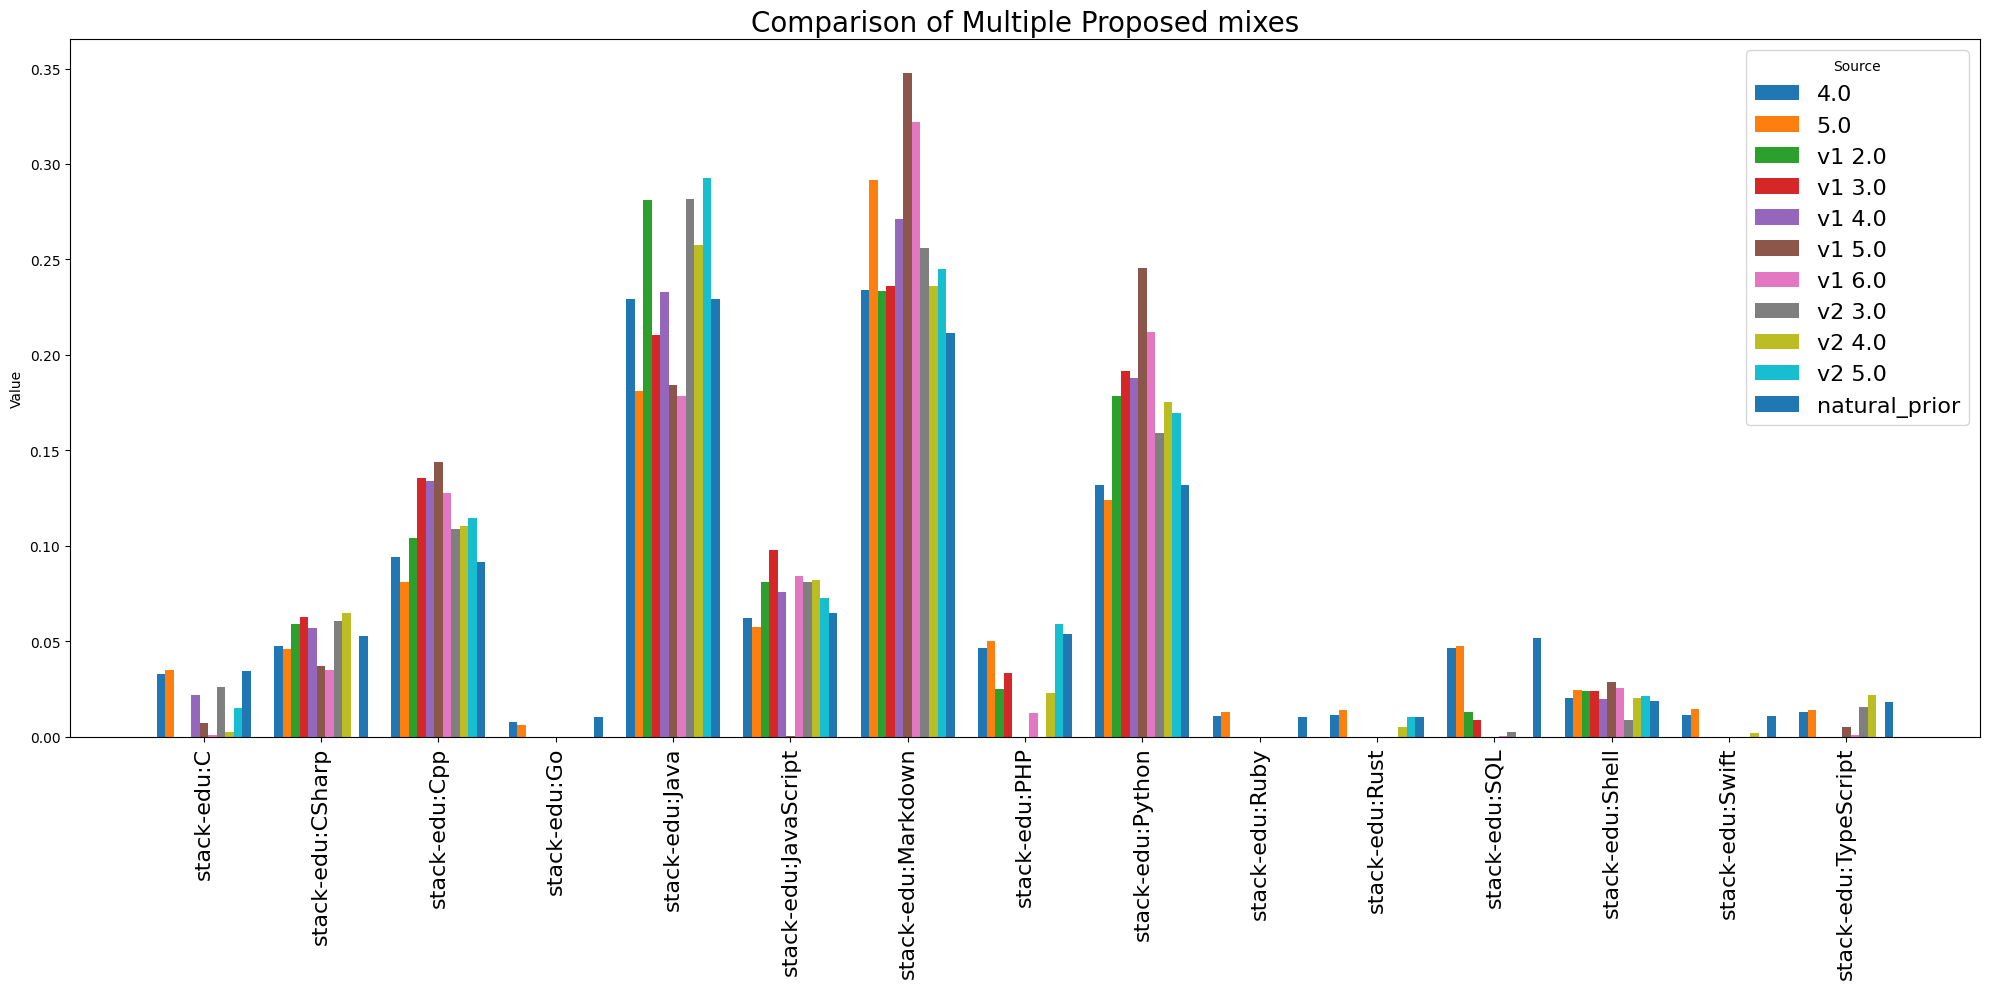

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define your dictionaries (you can add as many as you want)
rep_stack_mixes = dict(sorted(rep_stack_mixes.items()))
rep_stack_mixes.update({"natural_prior": stack_natural})

# Step 2: Collect all unique keys
all_keys = sorted(set().union(*[d.keys() for d in rep_stack_mixes.values()]))

# Step 3: Extract values for each dict, aligning with `all_keys`
values_matrix = [
    [d.get(k, 0) for k in all_keys]
    for d in rep_stack_mixes.values()
]

# Step 4: Plot grouped bars with annotations
n_dicts = len(rep_stack_mixes)
x = np.arange(len(all_keys))
bar_width = 0.8 / n_dicts

fig, ax = plt.subplots(figsize=(20, 10))

for i, (label, values) in enumerate(zip(rep_stack_mixes.keys(), values_matrix)):
    offset = (i - (n_dicts - 1) / 2) * bar_width
    bars = ax.bar(x + offset, values, width=bar_width, label=label)

    # Annotate each bar
    """ for bar in bars:
        height = bar.get_height()+0.01
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=90
            )"""

# Step 5: Format the plot
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
ax.set_ylabel("Value")
ax.set_title("Comparison of Multiple Proposed mixes", fontsize=20)
ax.legend(title="Source", fontsize=16)
plt.tight_layout()
plt.show()


In [38]:
"""rep_stack_mixes = {}
for rep, mix in sweep_repetition_factor_mixes.items():
    print(f"Repetition factor: {rep}")
    topic_mix = get_topic_mix("stack-edu", mix)
    rep_stack_mixes[rep] = topic_mix"""

unconstrained_mix_stack = get_topic_mix("pes2o", unconstrained_mix)

stack_natural = {k: v for k,v in priors[0].items() if k.startswith("pes2o:")}
total = sum(stack_natural.values())
stack_natural = {k: v / total for k, v in stack_natural.items()}

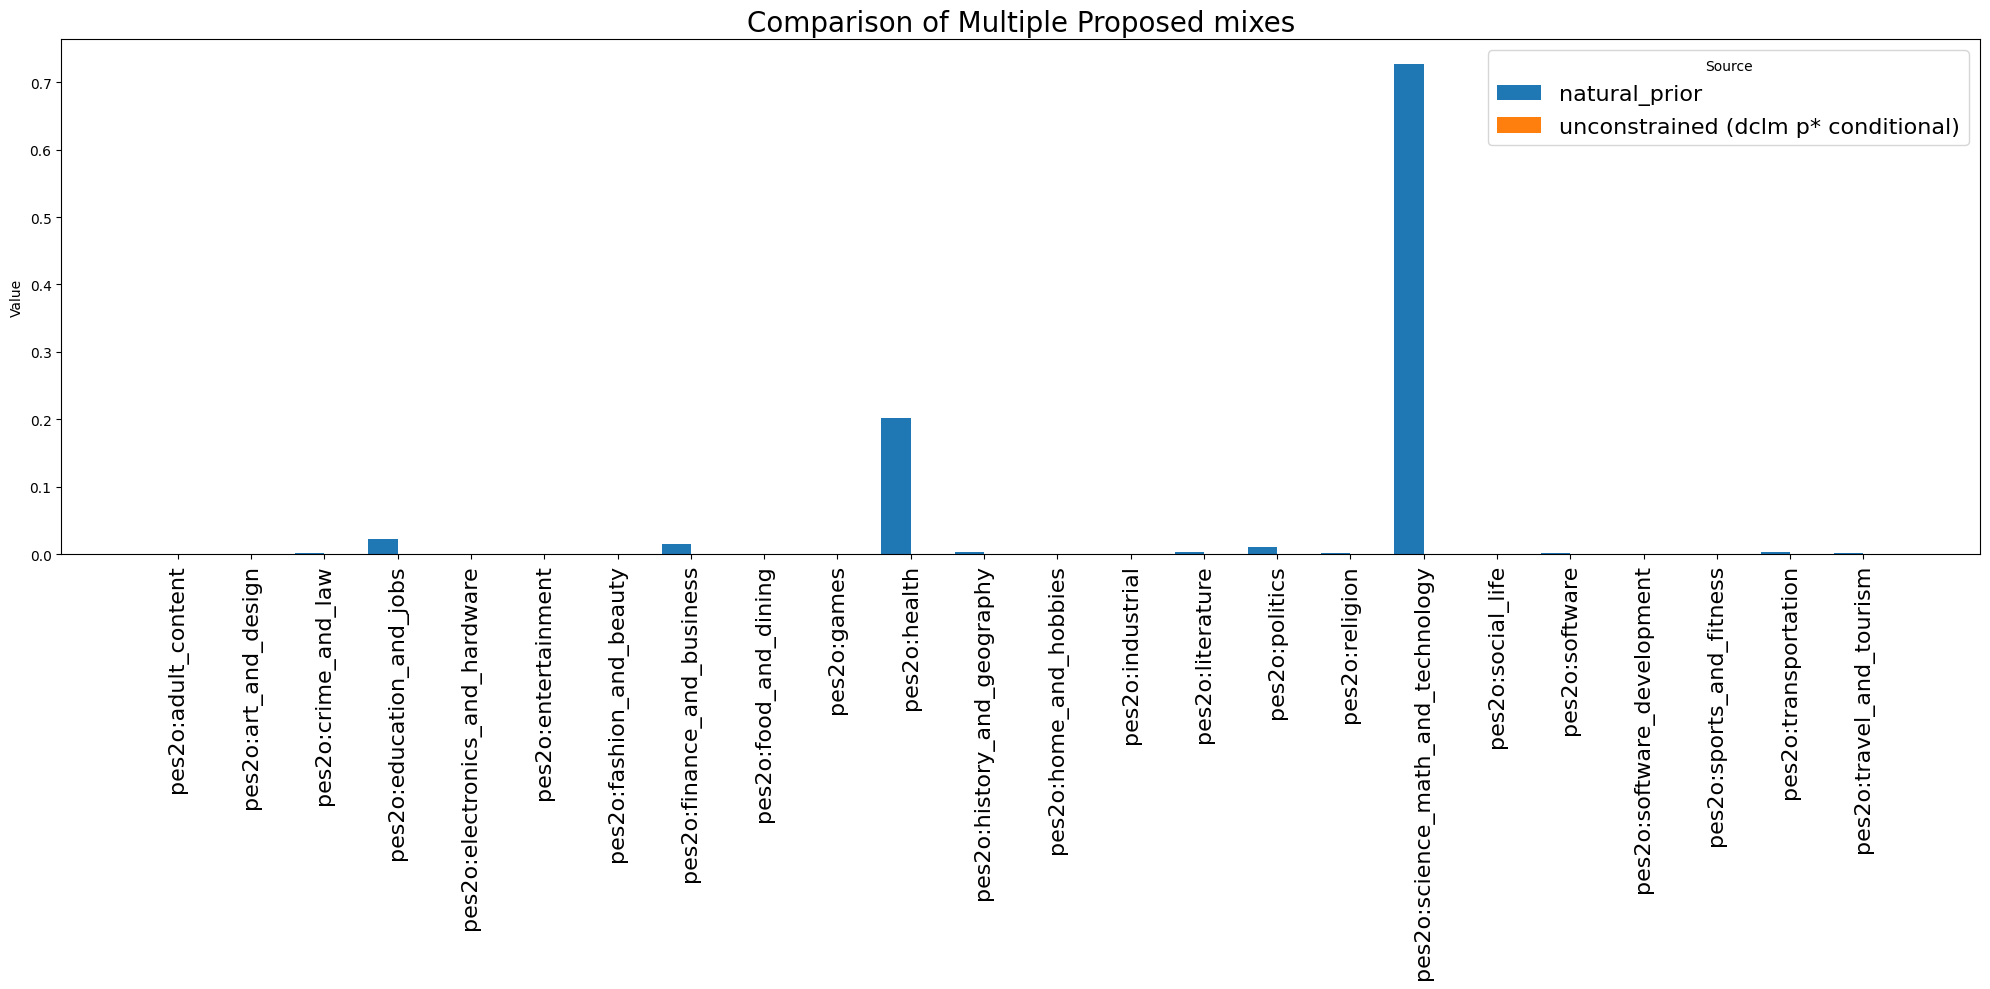

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define your dictionaries (you can add as many as you want)
rep_stack_mixes = {}# dict(sorted(rep_stack_mixes.items()))
rep_stack_mixes.update({"natural_prior": stack_natural, "unconstrained (dclm p* conditional)": unconstrained_mix_stack})    

# Step 2: Collect all unique keys
all_keys = sorted(set().union(*[d.keys() for d in rep_stack_mixes.values()]))

# Step 3: Extract values for each dict, aligning with `all_keys`
values_matrix = [
    [d.get(k, 0) for k in all_keys]
    for d in rep_stack_mixes.values()
]

# Step 4: Plot grouped bars with annotations
n_dicts = len(rep_stack_mixes)
x = np.arange(len(all_keys))
bar_width = 0.8 / n_dicts

fig, ax = plt.subplots(figsize=(20, 10))

for i, (label, values) in enumerate(zip(rep_stack_mixes.keys(), values_matrix)):
    offset = (i - (n_dicts - 1) / 2) * bar_width
    bars = ax.bar(x + offset, values, width=bar_width, label=label)

    # Annotate each bar
    """ for bar in bars:
        height = bar.get_height()+0.01
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=90
            )"""

# Step 5: Format the plot
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
ax.set_ylabel("Value")
ax.set_title("Comparison of Multiple Proposed mixes", fontsize=20)
ax.legend(title="Source", fontsize=16)
plt.tight_layout()
plt.show()


In [120]:
interaction_matrix = np.load("output/ee28fc9c/proposed_mixes/53d488f7cdc8748f/interaction_matrix.npy")

In [174]:
interaction_matrix_v2 = np.load("output/4252db91/e762b86546f4a8ba/interaction_matrix.npy")

In [130]:
metric_names = ['eval/downstream/mmlu_social_sciences_test_rc_5shot (BPB v2)',
 'eval/downstream/mmlu_humanities_test_rc_5shot (BPB v2)',
 'eval/downstream/mmlu_other_test_rc_5shot (BPB v2)',
 'eval/downstream/mmlu_stem_test_rc_5shot (BPB v2)',
 'eval/downstream/winogrande_val_rc_5shot (BPB v2)',
 'eval/downstream/socialiqa_val_rc_5shot (BPB v2)',
 'eval/downstream/piqa_val_rc_5shot (BPB v2)',
 'eval/downstream/minerva_math_algebra_gold_bpb_0shot (BPB v2)',
 'eval/downstream/minerva_math_counting_and_probability_gold_bpb_0shot (BPB v2)',
 'eval/downstream/minerva_math_geometry_gold_bpb_0shot (BPB v2)',
 'eval/downstream/minerva_math_intermediate_algebra_gold_bpb_0shot (BPB v2)',
 'eval/downstream/minerva_math_number_theory_gold_bpb_0shot (BPB v2)',
 'eval/downstream/minerva_math_prealgebra_gold_bpb_0shot (BPB v2)',
 'eval/downstream/minerva_math_precalculus_gold_bpb_0shot (BPB v2)',
 'eval/downstream/gsm8k_gold_bpb_5shot (BPB v2)',
 'eval/downstream/hellaswag_rc_5shot (BPB v2)',
 'eval/downstream/csqa_val_rc_5shot (BPB v2)',
 'eval/downstream/codex_mbpp_gold_bpb_0shot (BPB v2)',
 'eval/downstream/codex_humaneval_gold_bpb_0shot (BPB v2)',
 'eval/downstream/arc_easy_test_rc_5shot (BPB v2)',
 'eval/downstream/arc_challenge_test_rc_5shot (BPB v2)',
 'basic_skills_arithmetic:rc::olmes',
 'basic_skills_coding:rc::olmes',
 'basic_skills_common_knowledge:rc::olmes',
 'basic_skills_logical_reasoning:rc::olmes',
 'basic_skills_string_operations:rc::olmes',
 'basic_skills_pattern:rc::olmes',
 'mt_mbpp:bash',
 'mt_mbpp:c',
 'mt_mbpp:cpp',
 'mt_mbpp:csharp',
 'mt_mbpp:go',
 'mt_mbpp:haskell',
 'mt_mbpp:java',
 'mt_mbpp:javascript',
 'mt_mbpp:matlab',
 'mt_mbpp:php',
 'mt_mbpp:python',
 'mt_mbpp:r',
 'mt_mbpp:ruby',
 'mt_mbpp:rust',
 'mt_mbpp:scala',
 'mt_mbpp:swift',
 'mt_mbpp:typescript',
 'medmcqa:rc:bpb::none',
 'lambada',
 'sciq:bpb::olmo1',
 'squad:rc:bpb::gen2mc',
 'naturalqs:rc:bpb::gen2mc',
 'jeopardy:rc:bpb::gen2mc',
 'drop:rc:bpb::gen2mc',
 'coqa:rc:bpb::gen2mc',
 'ultrachat_masked_ppl',
 'wildchat_masked_ppl']

In [176]:
metric_names_v2 = ['arc_challenge:rc::olmes:full', 'arc_easy:rc::olmes:full', 'basic_skills_arithmetic:rc::olmes', 'basic_skills_coding:rc::olmes', 'basic_skills_common_knowledge:rc::olmes', 'basic_skills_logical_reasoning:rc::olmes', 'basic_skills_pattern:rc::olmes', 'basic_skills_string_operations:rc::olmes', 'codex_humaneval:3shot:bpb::none', 'coqa:rc::gen2mc', 'csqa:rc::olmes:full', 'drop:rc::gen2mc', 'hellaswag:rc::olmes:full', 'jeopardy:rc::gen2mc', 'lambada', 'mbpp:3shot:bpb::none', 'medmcqa:rc::none', 'minerva_math_algebra::olmes', 'minerva_math_counting_and_probability::olmes', 'minerva_math_geometry::olmes', 'minerva_math_intermediate_algebra::olmes', 'minerva_math_number_theory::olmes', 'minerva_math_prealgebra::olmes', 'minerva_math_precalculus::olmes', 'mt_mbpp:bash', 'mt_mbpp:c', 'mt_mbpp:cpp', 'mt_mbpp:csharp', 'mt_mbpp:go', 'mt_mbpp:haskell', 'mt_mbpp:java', 'mt_mbpp:javascript', 'mt_mbpp:matlab', 'mt_mbpp:php', 'mt_mbpp:python', 'mt_mbpp:r', 'mt_mbpp:ruby', 'mt_mbpp:rust', 'mt_mbpp:scala', 'mt_mbpp:swift', 'mt_mbpp:typescript', 'naturalqs:rc::gen2mc', 'piqa:rc::olmes:full', 'sciq::olmo1', 'socialiqa:rc::olmes:full', 'squad:rc::gen2mc', 'ultrachat_masked_ppl', 'wildchat_masked_ppl', 'winogrande:rc::olmes:full', 'mmlu_stem', 'mmlu_other', 'mmlu_social_sciences', 'mmlu_humanities']


In [172]:
sorted(list(zip(interaction_matrix[:, 52], metric_names)))

[(-121.95758056640625, 'mt_mbpp:go'),
 (-16.62735366821289, 'mt_mbpp:c'),
 (-13.923957824707031, 'mt_mbpp:java'),
 (-13.656794548034668, 'basic_skills_pattern:rc::olmes'),
 (-11.490986824035645, 'mt_mbpp:haskell'),
 (-10.942366600036621, 'mt_mbpp:php'),
 (-8.494211196899414, 'mt_mbpp:scala'),
 (-8.422219276428223, 'mt_mbpp:bash'),
 (-6.552469730377197, 'mt_mbpp:ruby'),
 (-5.308974266052246, 'mt_mbpp:rust'),
 (-4.945262908935547, 'eval/downstream/winogrande_val_rc_5shot (BPB v2)'),
 (-4.6040472984313965, 'mt_mbpp:javascript'),
 (-4.579841136932373, 'eval/downstream/csqa_val_rc_5shot (BPB v2)'),
 (-4.521645545959473, 'mt_mbpp:r'),
 (-4.350728511810303, 'mt_mbpp:csharp'),
 (-4.13554573059082, 'mt_mbpp:cpp'),
 (-3.6969053745269775, 'eval/downstream/mmlu_other_test_rc_5shot (BPB v2)'),
 (-3.430121898651123, 'mt_mbpp:matlab'),
 (-3.3791463375091553, 'eval/downstream/arc_challenge_test_rc_5shot (BPB v2)'),
 (-3.318647861480713, 'mt_mbpp:python'),
 (-2.5977671146392822,
  'eval/downstream/mine

In [178]:
interaction_matrix_v2.shape

(53, 67)

In [179]:
sorted(list(zip(interaction_matrix_v2[:, 54], metric_names_v2)))

[(-93.09701538085938, 'mt_mbpp:java'),
 (-17.35540771484375, 'mt_mbpp:c'),
 (-14.507027626037598, 'mt_mbpp:csharp'),
 (-13.227872848510742, 'mt_mbpp:scala'),
 (-10.163291931152344, 'mt_mbpp:r'),
 (-9.387493133544922, 'mt_mbpp:matlab'),
 (-9.231765747070312, 'mt_mbpp:javascript'),
 (-8.202436447143555, 'mt_mbpp:cpp'),
 (-7.407430648803711, 'mt_mbpp:go'),
 (-6.6883544921875, 'mt_mbpp:rust'),
 (-6.3208136558532715, 'mt_mbpp:typescript'),
 (-5.130005359649658, 'mbpp:3shot:bpb::none'),
 (-4.857791423797607, 'mt_mbpp:ruby'),
 (-4.642581462860107, 'basic_skills_coding:rc::olmes'),
 (-4.581198692321777, 'mt_mbpp:python'),
 (-4.293400287628174, 'mt_mbpp:php'),
 (-3.7532429695129395, 'mt_mbpp:swift'),
 (-2.7901360988616943, 'codex_humaneval:3shot:bpb::none'),
 (-1.9656997919082642, 'minerva_math_precalculus::olmes'),
 (-1.2201095819473267, 'mt_mbpp:bash'),
 (-1.2050254344940186, 'minerva_math_intermediate_algebra::olmes'),
 (-1.0828120708465576, 'minerva_math_algebra::olmes'),
 (-0.7952936887741

In [171]:
list(old_priors[0].keys()).index("stack-edu:Java")

52

In [254]:
total_pes2o = 0
count = 0
for i in range(2, 26):
    total_pes2o += interaction_matrix_v2[:, i].sum()
    count += 1
    print(interaction_matrix_v2[:, i].sum())

print(f"Total PES2O: {total_pes2o}, Average: {total_pes2o / count}")

2.1270663049072027
-11.45562211656943
31.537586649414152
-56.70009743887931
1.5601541546639055
1.9090436789992964
2.0952961508155568
42.95642776414752
1.7712485456140712
36.244345061481
-15.66970566578675
-3.053897760808468
2.248443316188059
-47.5224758638069
-49.509425662690774
-60.18950880179182
-4.90093112969771
-13.077014280017465
6.916143890062813
-5.400832214858383
17.345771017484367
-53.187001100275666
54.38347224025347
-15.514967358205467
Total PES2O: -135.08648061935673, Average: -5.628603359139864


In [255]:
total_s2pdf = 0
count = 0
for i in range(26, 50):
    count += 1
    print(interaction_matrix_v2[:, i].sum())
    total_s2pdf += interaction_matrix_v2[:, i].sum()

print(f"Total S2PDF: {total_s2pdf}, Average: {total_s2pdf / count}")

114.22578932973556
-29.760303914546967
-6.954747820505872
-7.485827344469726
-20.144887168891728
-71.82966026989743
-10.629860392771661
45.684072856325656
-48.04371639993042
-36.84711370617151
-12.473071264103055
-15.343586045317352
-60.73849156405777
-3.3690978777594864
0.22415218129754066
-12.280400411953451
1.9202653346583247
-21.819535837508738
6.744097393006086
-12.909510059515014
-81.63504601025488
-6.649132349528372
-18.8696077442728
-99.13842772060889
Total S2PDF: -408.12364680704195, Average: -17.005151950293413


In [249]:
for i in range(50, 65):
    print(interaction_matrix_v2[:, i].sum())

-276.5343604851514
-69.86946315038949
-322.95434883981943
-348.36139972507954
-231.12390024773777
-448.11277768947184
-202.63468548003584
-222.80395162291825
-675.6622694809921
-454.9134005866945
-493.6800024956465
-108.21284339297563
-375.74110871274024
-432.98081101849675
-610.1950836870819


In [175]:
list(priors[0].keys()).index("stack-edu:Java")

78

## Interaction matrix

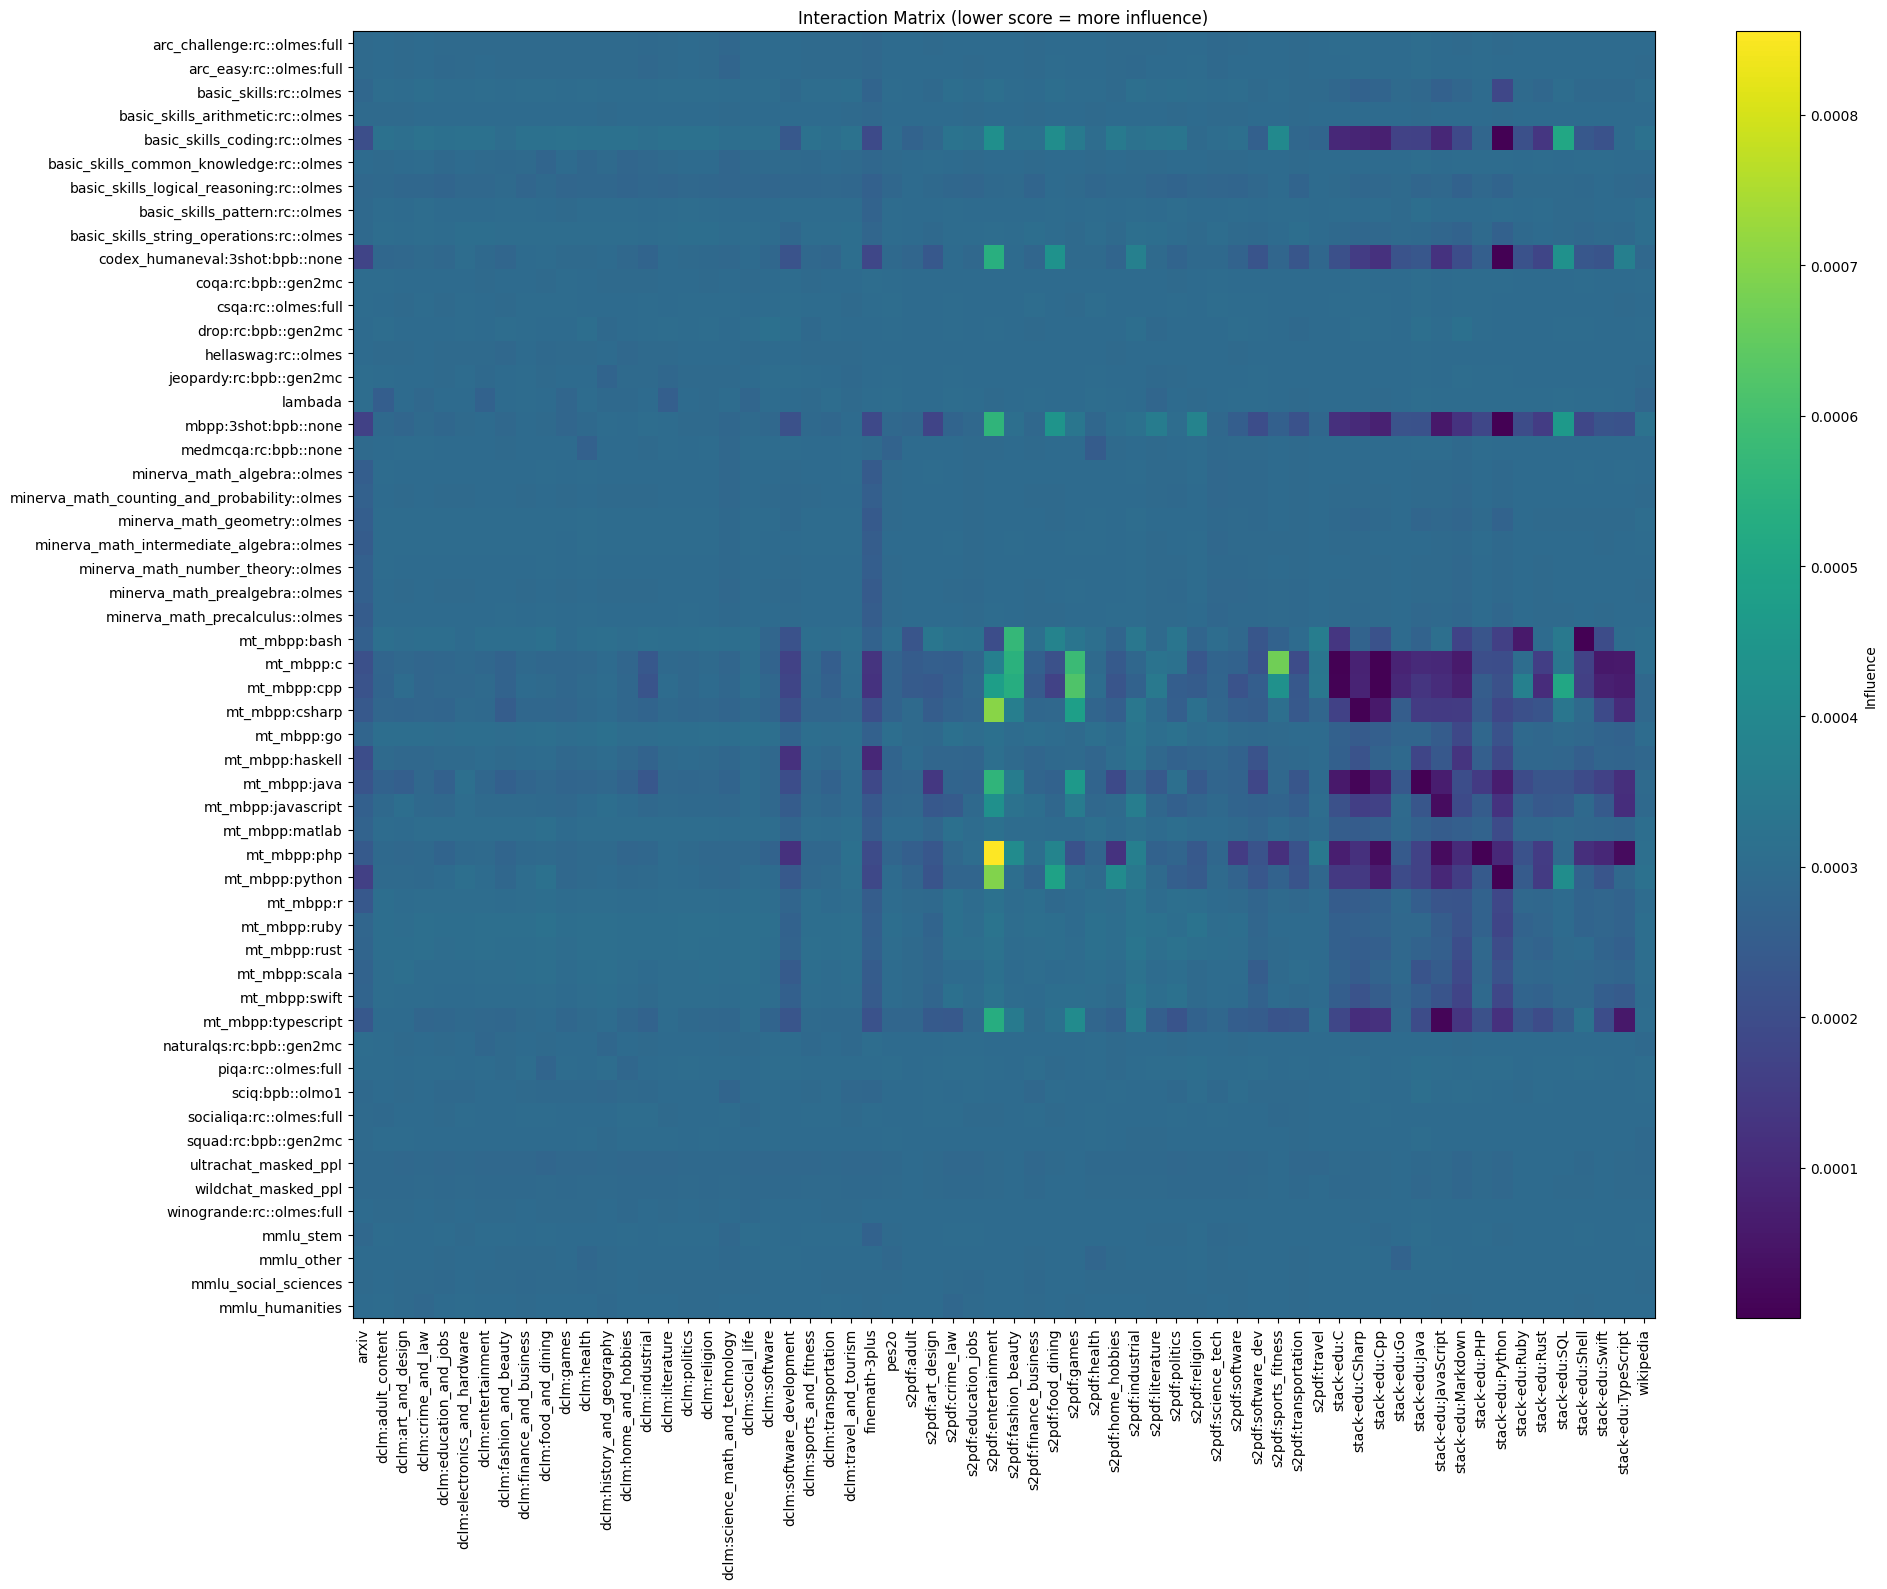

In [76]:
interaction_matrix = np.load("output/ee28fc9c/83dbe42176886b06/interaction_matrix.npy")


domain_names = ['arxiv', 'dclm:adult_content', 'dclm:art_and_design', 'dclm:crime_and_law', 'dclm:education_and_jobs', 'dclm:electronics_and_hardware', 'dclm:entertainment', 'dclm:fashion_and_beauty', 'dclm:finance_and_business', 'dclm:food_and_dining', 'dclm:games', 'dclm:health', 'dclm:history_and_geography', 'dclm:home_and_hobbies', 'dclm:industrial', 'dclm:literature', 'dclm:politics', 'dclm:religion', 'dclm:science_math_and_technology', 'dclm:social_life', 'dclm:software', 'dclm:software_development', 'dclm:sports_and_fitness', 'dclm:transportation', 'dclm:travel_and_tourism', 'finemath-3plus', 'pes2o', 's2pdf:adult', 's2pdf:art_design', 's2pdf:crime_law', 's2pdf:education_jobs', 's2pdf:entertainment', 's2pdf:fashion_beauty', 's2pdf:finance_business', 's2pdf:food_dining', 's2pdf:games', 's2pdf:health', 's2pdf:home_hobbies', 's2pdf:industrial', 's2pdf:literature', 's2pdf:politics', 's2pdf:religion', 's2pdf:science_tech', 's2pdf:software', 's2pdf:software_dev', 's2pdf:sports_fitness', 's2pdf:transportation', 's2pdf:travel', 'stack-edu:C', 'stack-edu:CSharp', 'stack-edu:Cpp', 'stack-edu:Go', 'stack-edu:Java', 'stack-edu:JavaScript', 'stack-edu:Markdown', 'stack-edu:PHP', 'stack-edu:Python', 'stack-edu:Ruby', 'stack-edu:Rust', 'stack-edu:SQL', 'stack-edu:Shell', 'stack-edu:Swift', 'stack-edu:TypeScript', 'wikipedia']
metric_names = ['arc_challenge:rc::olmes:full', 'arc_easy:rc::olmes:full', 'basic_skills:rc::olmes', 'basic_skills_arithmetic:rc::olmes', 'basic_skills_coding:rc::olmes', 'basic_skills_common_knowledge:rc::olmes', 'basic_skills_logical_reasoning:rc::olmes', 'basic_skills_pattern:rc::olmes', 'basic_skills_string_operations:rc::olmes', 'codex_humaneval:3shot:bpb::none', 'coqa:rc:bpb::gen2mc', 'csqa:rc::olmes:full', 'drop:rc:bpb::gen2mc', 'hellaswag:rc::olmes', 'jeopardy:rc:bpb::gen2mc', 'lambada', 'mbpp:3shot:bpb::none', 'medmcqa:rc:bpb::none', 'minerva_math_algebra::olmes', 'minerva_math_counting_and_probability::olmes', 'minerva_math_geometry::olmes', 'minerva_math_intermediate_algebra::olmes', 'minerva_math_number_theory::olmes', 'minerva_math_prealgebra::olmes', 'minerva_math_precalculus::olmes', 'mt_mbpp:bash', 'mt_mbpp:c', 'mt_mbpp:cpp', 'mt_mbpp:csharp', 'mt_mbpp:go', 'mt_mbpp:haskell', 'mt_mbpp:java', 'mt_mbpp:javascript', 'mt_mbpp:matlab', 'mt_mbpp:php', 'mt_mbpp:python', 'mt_mbpp:r', 'mt_mbpp:ruby', 'mt_mbpp:rust', 'mt_mbpp:scala', 'mt_mbpp:swift', 'mt_mbpp:typescript', 'naturalqs:rc:bpb::gen2mc', 'piqa:rc::olmes:full', 'sciq:bpb::olmo1', 'socialiqa:rc::olmes:full', 'squad:rc:bpb::gen2mc', 'ultrachat_masked_ppl', 'wildchat_masked_ppl', 'winogrande:rc::olmes:full', 'mmlu_stem', 'mmlu_other', 'mmlu_social_sciences', 'mmlu_humanities']


from scipy.special import softmax

softmax_matrix = softmax(interaction_matrix*0.1)  # axis=1 = per row (metric)

plt.figure(figsize=(20, 16))
plt.imshow(softmax_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Influence')

plt.xticks(ticks=np.arange(len(domain_names)), labels=domain_names, rotation=90)
plt.yticks(ticks=np.arange(len(metric_names)), labels=metric_names)
plt.title("Interaction Matrix (lower score = more influence)")
plt.tight_layout()

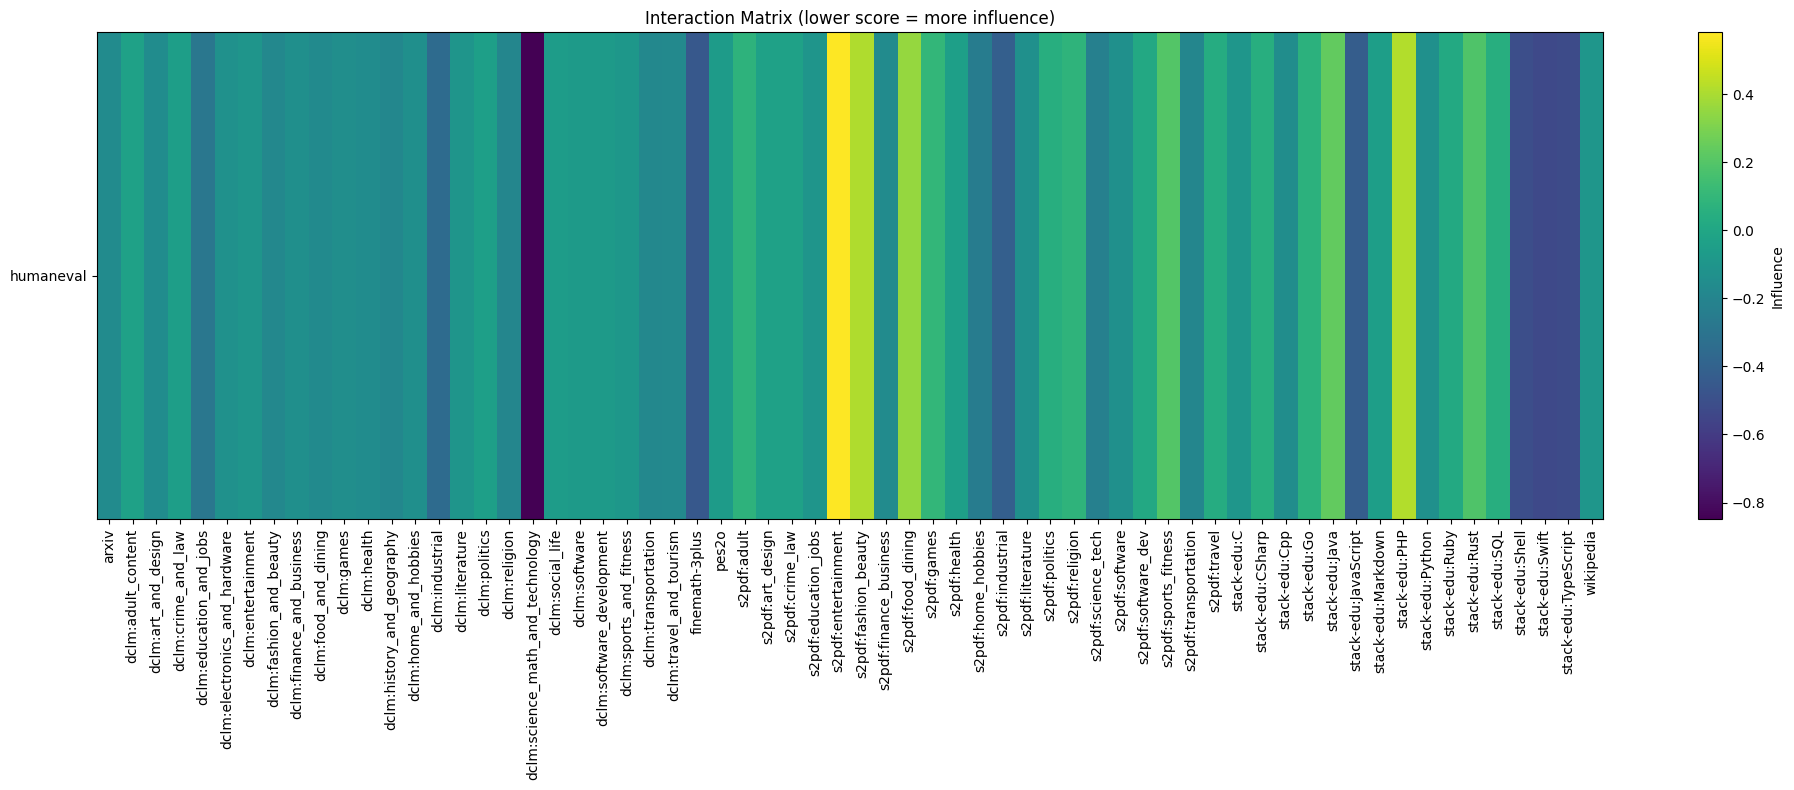

In [53]:
interaction_matrix = np.load("output/ee28fc9c/53d488f7cdc8748f/interaction_matrix.npy")

domain_names = ['arxiv', 'dclm:adult_content', 'dclm:art_and_design', 'dclm:crime_and_law', 'dclm:education_and_jobs', 'dclm:electronics_and_hardware', 'dclm:entertainment', 'dclm:fashion_and_beauty', 'dclm:finance_and_business', 'dclm:food_and_dining', 'dclm:games', 'dclm:health', 'dclm:history_and_geography', 'dclm:home_and_hobbies', 'dclm:industrial', 'dclm:literature', 'dclm:politics', 'dclm:religion', 'dclm:science_math_and_technology', 'dclm:social_life', 'dclm:software', 'dclm:software_development', 'dclm:sports_and_fitness', 'dclm:transportation', 'dclm:travel_and_tourism', 'finemath-3plus', 'pes2o', 's2pdf:adult', 's2pdf:art_design', 's2pdf:crime_law', 's2pdf:education_jobs', 's2pdf:entertainment', 's2pdf:fashion_beauty', 's2pdf:finance_business', 's2pdf:food_dining', 's2pdf:games', 's2pdf:health', 's2pdf:home_hobbies', 's2pdf:industrial', 's2pdf:literature', 's2pdf:politics', 's2pdf:religion', 's2pdf:science_tech', 's2pdf:software', 's2pdf:software_dev', 's2pdf:sports_fitness', 's2pdf:transportation', 's2pdf:travel', 'stack-edu:C', 'stack-edu:CSharp', 'stack-edu:Cpp', 'stack-edu:Go', 'stack-edu:Java', 'stack-edu:JavaScript', 'stack-edu:Markdown', 'stack-edu:PHP', 'stack-edu:Python', 'stack-edu:Ruby', 'stack-edu:Rust', 'stack-edu:SQL', 'stack-edu:Shell', 'stack-edu:Swift', 'stack-edu:TypeScript', 'wikipedia']
metric_names = ['humaneval']
interaction_matrix = interaction_matrix[[1]]

plt.figure(figsize=(20, 8))
plt.imshow(interaction_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Influence')

plt.xticks(ticks=np.arange(len(domain_names)), labels=domain_names, rotation=90)
plt.yticks(ticks=np.arange(len(metric_names)), labels=metric_names)
plt.title("Interaction Matrix (lower score = more influence)")
plt.tight_layout()

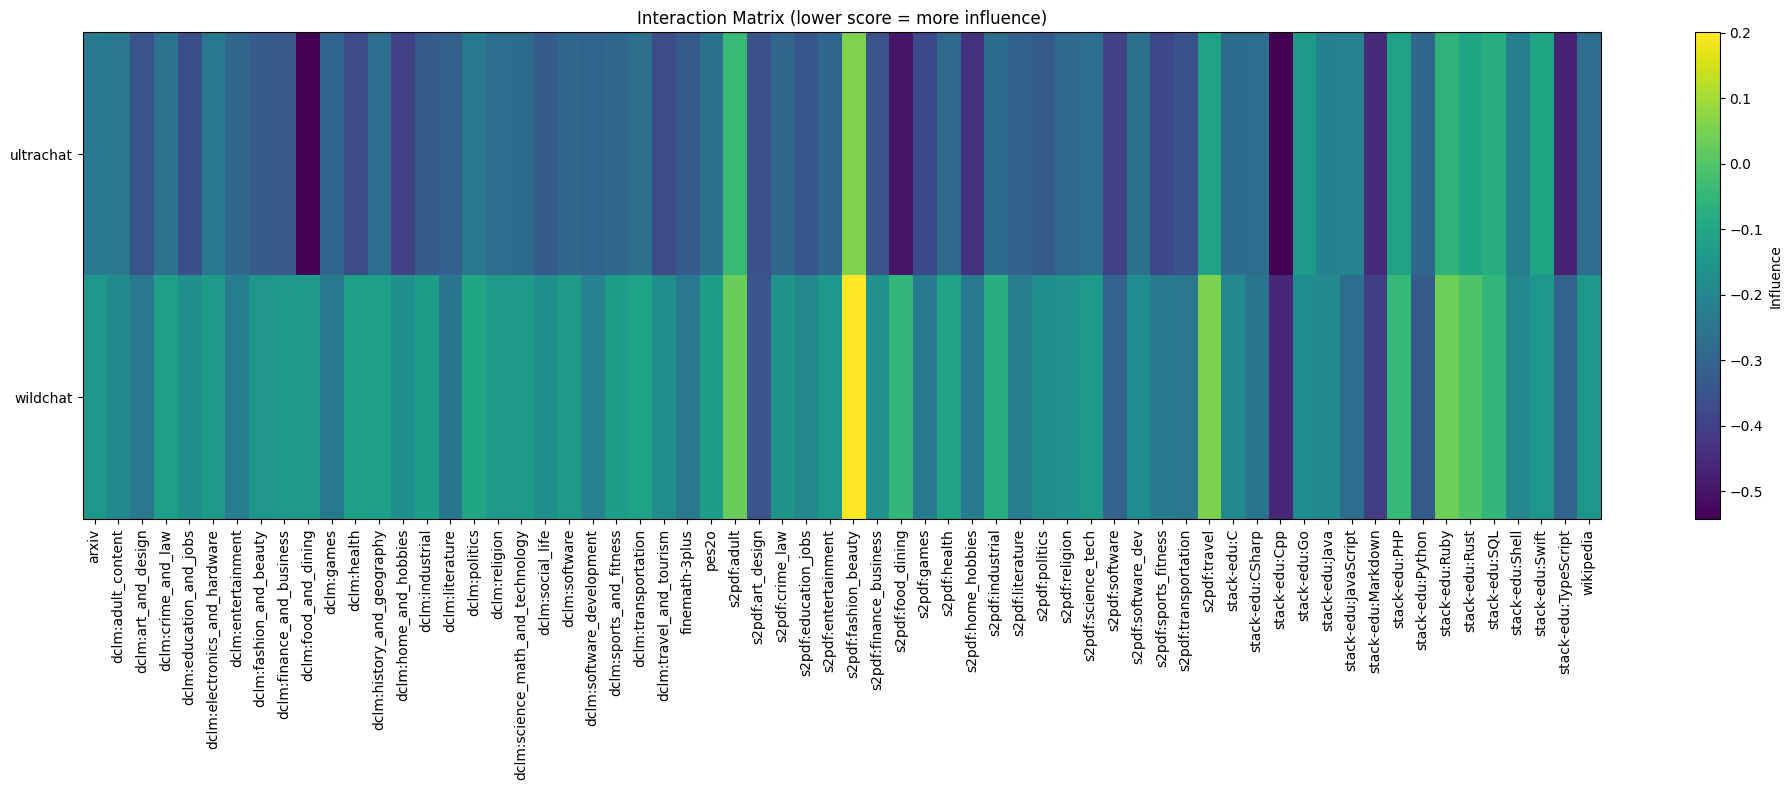

In [15]:
interaction_matrix = np.load("output/ee28fc9c/53d488f7cdc8748f/interaction_matrix.npy")


domain_names = ['arxiv', 'dclm:adult_content', 'dclm:art_and_design', 'dclm:crime_and_law', 'dclm:education_and_jobs', 'dclm:electronics_and_hardware', 'dclm:entertainment', 'dclm:fashion_and_beauty', 'dclm:finance_and_business', 'dclm:food_and_dining', 'dclm:games', 'dclm:health', 'dclm:history_and_geography', 'dclm:home_and_hobbies', 'dclm:industrial', 'dclm:literature', 'dclm:politics', 'dclm:religion', 'dclm:science_math_and_technology', 'dclm:social_life', 'dclm:software', 'dclm:software_development', 'dclm:sports_and_fitness', 'dclm:transportation', 'dclm:travel_and_tourism', 'finemath-3plus', 'pes2o', 's2pdf:adult', 's2pdf:art_design', 's2pdf:crime_law', 's2pdf:education_jobs', 's2pdf:entertainment', 's2pdf:fashion_beauty', 's2pdf:finance_business', 's2pdf:food_dining', 's2pdf:games', 's2pdf:health', 's2pdf:home_hobbies', 's2pdf:industrial', 's2pdf:literature', 's2pdf:politics', 's2pdf:religion', 's2pdf:science_tech', 's2pdf:software', 's2pdf:software_dev', 's2pdf:sports_fitness', 's2pdf:transportation', 's2pdf:travel', 'stack-edu:C', 'stack-edu:CSharp', 'stack-edu:Cpp', 'stack-edu:Go', 'stack-edu:Java', 'stack-edu:JavaScript', 'stack-edu:Markdown', 'stack-edu:PHP', 'stack-edu:Python', 'stack-edu:Ruby', 'stack-edu:Rust', 'stack-edu:SQL', 'stack-edu:Shell', 'stack-edu:Swift', 'stack-edu:TypeScript', 'wikipedia']
metric_names = ['arc_challenge:rc::olmes:full', 'arc_easy:rc::olmes:full', 'basic_skills:rc::olmes', 'basic_skills_arithmetic:rc::olmes', 'basic_skills_coding:rc::olmes', 'basic_skills_common_knowledge:rc::olmes', 'basic_skills_logical_reasoning:rc::olmes', 'basic_skills_pattern:rc::olmes', 'basic_skills_string_operations:rc::olmes', 'codex_humaneval:3shot:bpb::none', 'coqa:rc:bpb::gen2mc', 'csqa:rc::olmes:full', 'drop:rc:bpb::gen2mc', 'hellaswag:rc::olmes', 'jeopardy:rc:bpb::gen2mc', 'lambada', 'mbpp:3shot:bpb::none', 'medmcqa:rc:bpb::none', 'minerva_math_algebra::olmes', 'minerva_math_counting_and_probability::olmes', 'minerva_math_geometry::olmes', 'minerva_math_intermediate_algebra::olmes', 'minerva_math_number_theory::olmes', 'minerva_math_prealgebra::olmes', 'minerva_math_precalculus::olmes', 'mt_mbpp:bash', 'mt_mbpp:c', 'mt_mbpp:cpp', 'mt_mbpp:csharp', 'mt_mbpp:go', 'mt_mbpp:haskell', 'mt_mbpp:java', 'mt_mbpp:javascript', 'mt_mbpp:matlab', 'mt_mbpp:php', 'mt_mbpp:python', 'mt_mbpp:r', 'mt_mbpp:ruby', 'mt_mbpp:rust', 'mt_mbpp:scala', 'mt_mbpp:swift', 'mt_mbpp:typescript', 'naturalqs:rc:bpb::gen2mc', 'piqa:rc::olmes:full', 'sciq:bpb::olmo1', 'socialiqa:rc::olmes:full', 'squad:rc:bpb::gen2mc', 'ultrachat_masked_ppl', 'wildchat_masked_ppl', 'winogrande:rc::olmes:full', 'mmlu_stem', 'mmlu_other', 'mmlu_social_sciences', 'mmlu_humanities']


metric_names = ['ultrachat', 'wildchat']

interaction_matrix = interaction_matrix[[47, 48], :]
plt.figure(figsize=(20, 8))
plt.imshow(interaction_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Influence')

plt.xticks(ticks=np.arange(len(domain_names)), labels=domain_names, rotation=90)
plt.yticks(ticks=np.arange(len(metric_names)), labels=metric_names)
plt.title("Interaction Matrix (lower score = more influence)")
plt.tight_layout()

# 30M results

In [72]:
experiment_groups = [#"2e6e1ff0", 
                     "fd7cab69", "41533660", "4f36a33e",
                     "660a6d04", "1b497b25", "00670414", "02a77d23"
                     ]

group_metrics = 'olmo3_offline_tasks'
workspace = "ai2-llm/regmixer"
ratios, metrics = load_X_Y(experiment_groups, group_metrics, workspace, None, priors)

from src.regmixer.eval.constants import GroupedWandbMetrics

eval_metric_group = GroupedWandbMetrics.olmo3_offline_tasks

aggregate_mmlu(metrics, eval_metric_group.value)

2025-06-09 18:37:30,641 - regmixer.eval.utils - INFO - Aggregating MMLU metrics...


(        run                                               name  index  \
 0  5zn4vt11  regmixer-superswarm-conditional-dclm-collapse-...      0   
 1  avgtdtxm  regmixer-superswarm-conditional-dclm-collapse-...      1   
 2  4ha03m59  regmixer-superswarm-conditional-dclm-collapse-...      2   
 3  qjk8lt5x  regmixer-superswarm-conditional-dclm-collapse-...      3   
 4  ftxhox7h  regmixer-superswarm-v1-log-linear-on-v2-fd7cab...      4   
 5  ppus2d5l  regmixer-superswarm-v2-conditional-dclm-415336...      5   
 6  58c113la       regmixer-superswarm-v2-natural-4f36a33e-0000      6   
 
    arc_challenge:rc::olmes  arc_easy:rc::olmes  \
 0                 1.551985            1.458228   
 1                 1.521479            1.443330   
 2                 1.549100            1.469758   
 3                 1.535004            1.465224   
 4                 1.570927            1.479581   
 5                 1.545690            1.497650   
 6                 1.571653            1.460243  

In [74]:
metrics['avg_bpb'] = metrics[metrics.columns[3:56]].mean(axis=1)

In [75]:
code_tasks = [
    'basic_skills_coding:rc::olmes',
    'mt_mbpp:bash', 'mt_mbpp:c',
    'mt_mbpp:cpp', 'mt_mbpp:csharp', 'mt_mbpp:go', 'mt_mbpp:haskell',
    'mt_mbpp:java', 'mt_mbpp:javascript', 'mt_mbpp:matlab', 'mt_mbpp:php',
    'mt_mbpp:python', 'mt_mbpp:r', 'mt_mbpp:ruby', 'mt_mbpp:rust',
    'mt_mbpp:scala', 'mt_mbpp:swift', 'mt_mbpp:typescript',
    'codex_humaneval:3shot::none',
    'mbpp:3shot::none'
]

In [76]:
metrics['code_bpb'] = metrics[code_tasks].mean(axis=1)

In [77]:
desc_to_name = {
    'DCLM-conditional-natural': 'regmixer-superswarm-v2-conditional-dclm-41533660-0000',
    'natural': 'regmixer-superswarm-v2-natural-4f36a33e-0000',
    #'DCLM-conditional-log-linear': 'regmixer-superswarm-v2-conditional-dclm-log-linear-2e6e1ff0-0000',
    'unconditional-log-linear-transfer': 'regmixer-superswarm-v1-log-linear-on-v2-fd7cab69-0000',
    'DCLM-conditional-log-linear-collapse-pes2o-3': 'regmixer-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-constraint-3-660a6d04-0000',
    'DCLM-conditional-log-linear-collapse-pes2o-4': 'regmixer-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-constraint-4-1b497b25-0000',
    'DCLM-conditional-log-linear-collapse-pes2o-5': 'regmixer-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-constraint-5-00670414-0000',
    'DCLM-conditional-log-linear-collapse-pes2o': 'regmixer-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-02a77d23-0000'

}

In [78]:
metrics.name.values

array(['regmixer-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-02a77d23-0000',
       'regmixer-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-constraint-3-660a6d04-0000',
       'regmixer-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-constraint-4-1b497b25-0000',
       'regmixer-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-constraint-5-00670414-0000',
       'regmixer-superswarm-v1-log-linear-on-v2-fd7cab69-0000',
       'regmixer-superswarm-v2-conditional-dclm-41533660-0000',
       'regmixer-superswarm-v2-natural-4f36a33e-0000'], dtype=object)

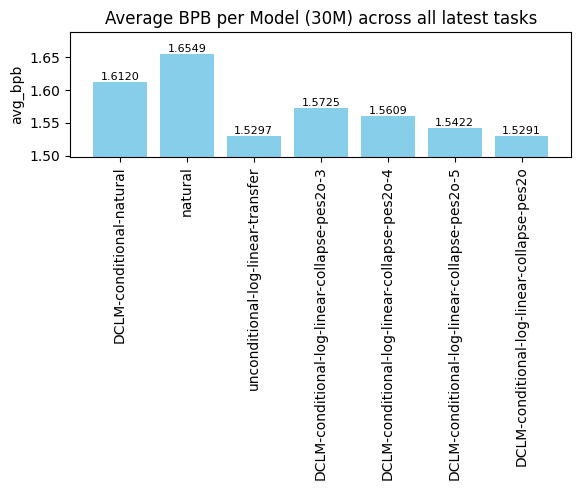

In [79]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

labels = list(desc_to_name.keys())
values = [metrics[metrics.name == name]['avg_bpb'].values[0] for desc, name in desc_to_name.items()]

# Assign colors (can customize later)
colors = ["skyblue" for _ in labels]

fig, ax = plt.subplots(figsize=(6, 5))

# Plot bars
bars = ax.bar(labels, values, color=colors)
ax.set_ylabel("avg_bpb")
ax.set_title("Average BPB per Model (30M) across all latest tasks")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim(min(values) * 0.98, max(values) * 1.02)
plt.tight_layout()

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{value:.4f}",       # format as needed (e.g., .2f or .3f)
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.show()



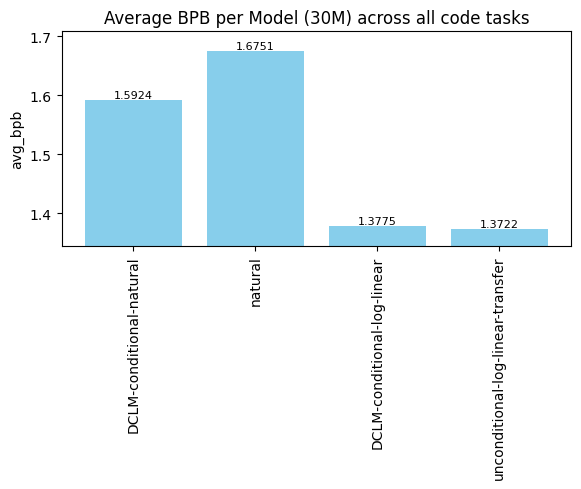

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

labels = list(desc_to_name.keys())
values = [metrics[metrics.name == name]['code_bpb'].values[0] for desc, name in desc_to_name.items()]

# Assign colors (can customize later)
colors = ["skyblue" for _ in labels]

fig, ax = plt.subplots(figsize=(6, 5))

# Plot bars
bars = ax.bar(labels, values, color=colors)
ax.set_ylabel("avg_bpb")
ax.set_title("Average BPB per Model (30M) across all code tasks")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim(min(values) * 0.98, max(values) * 1.02)
plt.tight_layout()

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{value:.4f}",       # format as needed (e.g., .2f or .3f)
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.show()



0.9680238524744105 -0.16869321387267044 0.11352580216527076 20


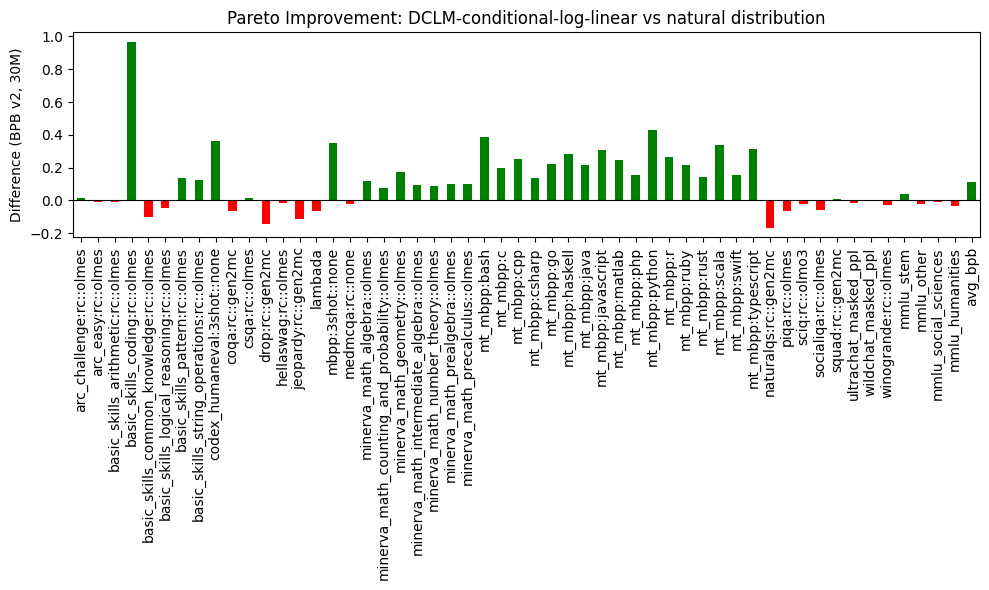

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = "regmixer-superswarm-v2-natural-4f36a33e-0000"
target_name = "regmixer-superswarm-v2-conditional-dclm-log-linear-2e6e1ff0-0000"

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: DCLM-conditional-log-linear vs natural distribution')
plt.ylabel('Difference (BPB v2, 30M)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# 1B results

In [174]:
experiment_groups = ["61de5e1e", "52749eca", "78403bc2", "f15e08c9",
                     "4ca6c07f",
                       "c1930276", "7e702ff7", "b65c9504",
                    "47953a8c", 
                     "2099326f", "0b61d5af"
                     ]

group_metrics = 'olmo3_offline_tasks'
workspace = "ai2-llm/olmo-cookbook"
ratios, metrics = load_X_Y(experiment_groups, group_metrics, workspace, None, priors)

from src.regmixer.eval.constants import GroupedWandbMetrics

eval_metric_group = GroupedWandbMetrics.olmo3_offline_tasks

aggregate_mmlu(metrics, eval_metric_group.value)

{'arxiv': False, 'dclm:adult_content': False, 'dclm:art_and_design': False, 'dclm:crime_and_law': False, 'dclm:education_and_jobs': False, 'dclm:electronics_and_hardware': False, 'dclm:entertainment': False, 'dclm:fashion_and_beauty': False, 'dclm:finance_and_business': False, 'dclm:food_and_dining': False, 'dclm:games': False, 'dclm:health': False, 'dclm:history_and_geography': False, 'dclm:home_and_hobbies': False, 'dclm:industrial': False, 'dclm:literature': False, 'dclm:politics': False, 'dclm:religion': False, 'dclm:science_math_and_technology': False, 'dclm:social_life': False, 'dclm:software': False, 'dclm:software_development': False, 'dclm:sports_and_fitness': False, 'dclm:transportation': False, 'dclm:travel_and_tourism': False, 'finemath-3plus': False, 'pes2o:adult_content': False, 'pes2o:art_and_design': False, 'pes2o:crime_and_law': False, 'pes2o:education_and_jobs': False, 'pes2o:electronics_and_hardware': False, 'pes2o:entertainment': False, 'pes2o:fashion_and_beauty': F

2025-06-09 03:09:30,421 - regmixer.eval.utils - INFO - Aggregating MMLU metrics...


(         run                                               name  index  \
 0   0w0kszo8  1b-5xC-superswarm-conditional-dclm-collapse-pe...      0   
 1   584e3vet  1b-5xC-superswarm-conditional-dclm-collapse-pe...      1   
 2   oox75yda  1b-5xC-superswarm-conditional-dclm-collapse-pe...      2   
 3   gxzgr44v  1b-5xC-superswarm-conditional-dclm-collapse-pe...      3   
 4   qmho4ub3  1b-5xC-superswarm-conditional-dclm-log-linear-...      4   
 5   6uhhnoh7  1b-5xC-superswarm-conditional-dclm-log-linear-...      5   
 6   v71yqr0i  1b-5xC-superswarm-conditional-dclm-log-linear-...      6   
 7   xejlm8wg  1b-5xC-superswarm-conditional-dclm-log-linear-...      7   
 8   9z11j0b9     1b-5xC-superswarm-v1-log-linear-on-v2-f15e08c9      8   
 9   cfvgzvod  1b-5xC-superswarm-v2-conditional-dclm-natural-...      9   
 10  q9clpqbs              1b-5xC-superswarm-v2-natural-52749eca     10   
 
     arc_challenge:rc::olmes  arc_easy:rc::olmes  \
 0                  0.823239            0.6341

In [59]:
metrics['avg_bpb'] = metrics[metrics.columns[3:57]].mean(axis=1)

In [60]:
metrics['code_bpb'] = metrics[code_tasks].mean(axis=1)

In [61]:
desc_to_name = {
  'DCLM-conditional-natural': '1b-5xC-superswarm-v2-conditional-dclm-natural-61de5e1e',
  'natural': '1b-5xC-superswarm-v2-natural-52749eca',
  'DCLM-conditional-log-linear': '1b-5xC-superswarm-conditional-dclm-log-linear-78403bc2',
  'unconditional-log-linear-transfer': '1b-5xC-superswarm-v1-log-linear-on-v2-f15e08c9',
  'DCLM-conditional-log-linear-constraint-3': '1b-5xC-superswarm-conditional-dclm-log-linear-constraint-3-4ca6c07f',
  'DCLM-conditional-log-linear-constraint-4': '1b-5xC-superswarm-conditional-dclm-log-linear-constraint-4-c1930276',
  'DCLM-conditional-log-linear-constraint-5': '1b-5xC-superswarm-conditional-dclm-log-linear-constraint-5-7e702ff7',
  'DCLM-conditional-collapse-pes2o-log-linear': '1b-5xC-superswarm-conditional-dclm-collapse-pes2o-log-linear-b65c9504',
  'DCLM-conditional-collapse-pes2o-log-linear-constraint-3': '1b-5xC-superswarm-conditional-dclm-collapse-pes2o-log-linear-constraint-3-47953a8c',
  'DCLM-conditional-collapse-pes2o-log-linear-constraint-4': '1b-5xC-superswarm-conditional-dclm-collapse-pes2o-log-linear-constraint-4-2099326f',
  'DCLM-conditional-collapse-pes2o-log-linear-constraint-5': '1b-5xC-superswarm-conditional-dclm-collapse-pes2o-log-linear-constraint-5-0b61d5af'

}

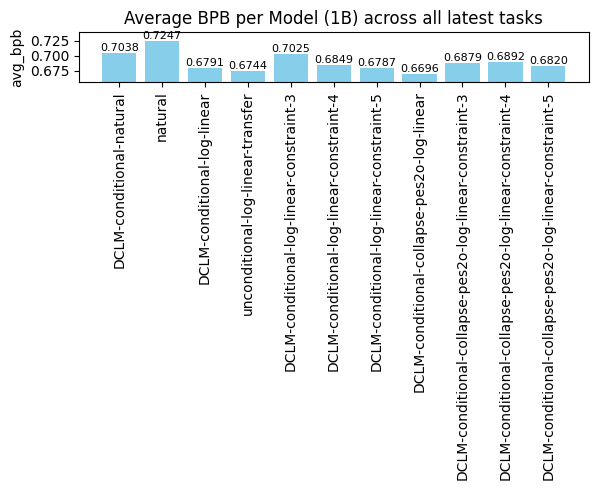

In [62]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

labels = list(desc_to_name.keys())
values = [metrics[metrics.name == name]['avg_bpb'].values[0] for desc, name in desc_to_name.items()]

# Assign colors (can customize later)
colors = ["skyblue" for _ in labels]

fig, ax = plt.subplots(figsize=(6, 5))

# Plot bars
bars = ax.bar(labels, values, color=colors)
ax.set_ylabel("avg_bpb")
ax.set_title("Average BPB per Model (1B) across all latest tasks")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim(min(values) * 0.98, max(values) * 1.02)
plt.tight_layout()

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{value:.4f}",       # format as needed (e.g., .2f or .3f)
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.show()



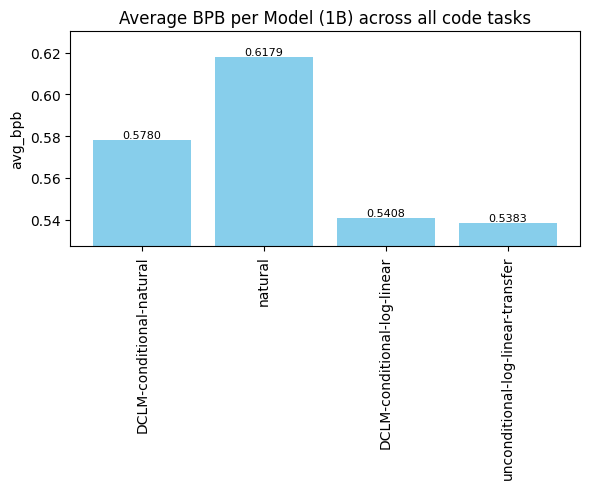

In [27]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

labels = list(desc_to_name.keys())
values = [metrics[metrics.name == name]['code_bpb'].values[0] for desc, name in desc_to_name.items()]

# Assign colors (can customize later)
colors = ["skyblue" for _ in labels]

fig, ax = plt.subplots(figsize=(6, 5))

# Plot bars
bars = ax.bar(labels, values, color=colors)
ax.set_ylabel("avg_bpb")
ax.set_title("Average BPB per Model (1B) across all code tasks")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim(min(values) * 0.98, max(values) * 1.02)
plt.tight_layout()

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{value:.4f}",       # format as needed (e.g., .2f or .3f)
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.show()



0.28464676008756595 -0.04480704079148523 0.04583683855285775 16


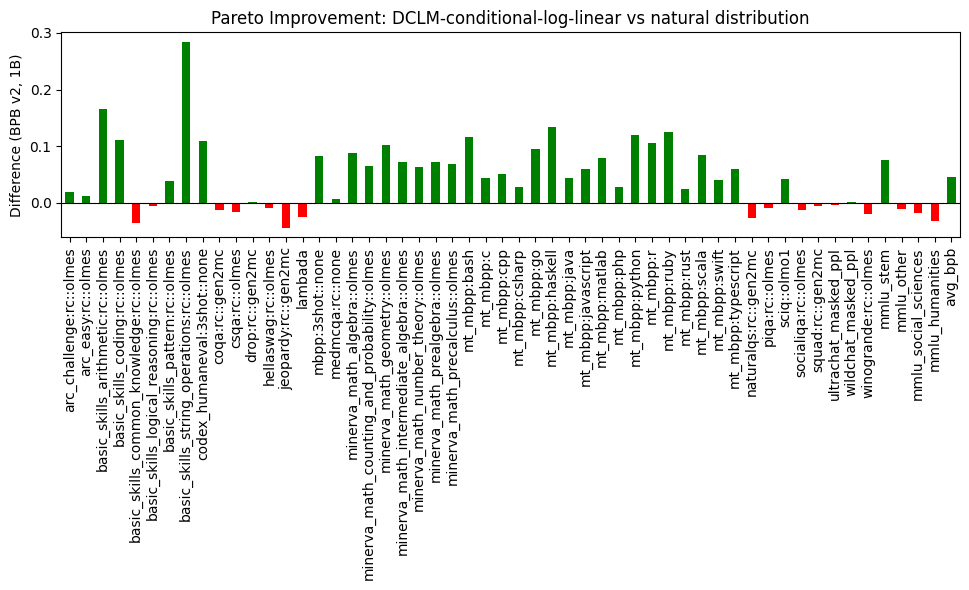

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = "1b-5xC-superswarm-v2-natural-52749eca"
target_name = "1b-5xC-superswarm-conditional-dclm-log-linear-78403bc2"

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: DCLM-conditional-log-linear vs natural distribution')
plt.ylabel('Difference (BPB v2, 1B)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


0.3291760859595687 -0.0679556381765073 0.05102048584750201 16


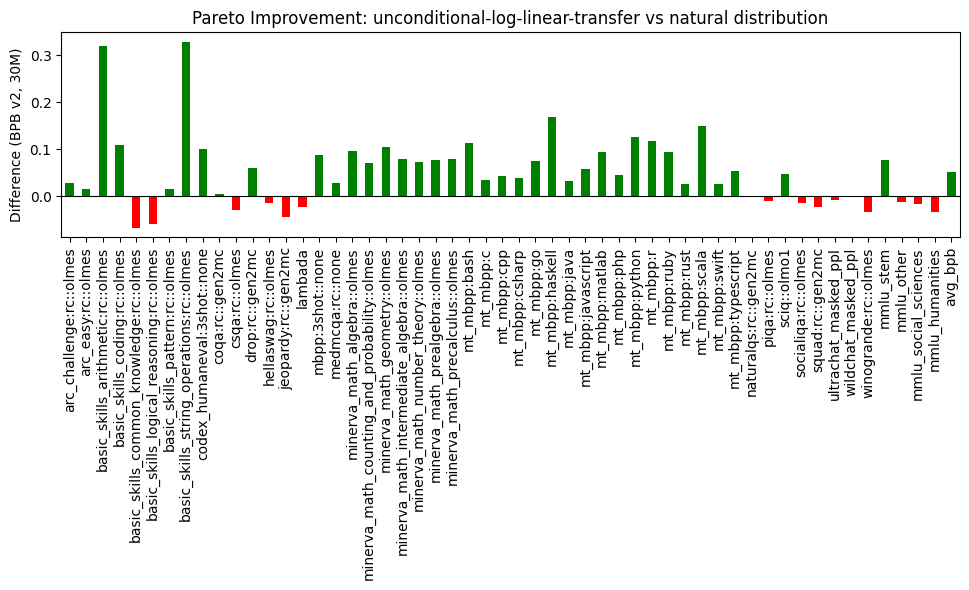

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = "1b-5xC-superswarm-v2-natural-52749eca"
target_name = "1b-5xC-superswarm-v1-log-linear-on-v2-f15e08c9"

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: unconditional-log-linear-transfer vs natural distribution')
plt.ylabel('Difference (BPB v2, 30M)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


0.30314141562946695 -0.057980556603372424 0.04598538905702411 17


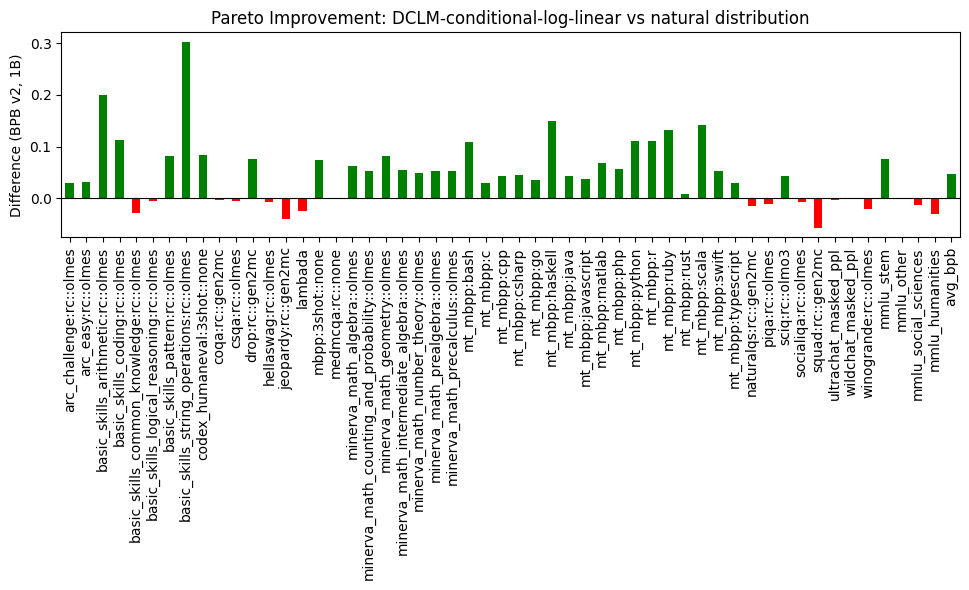

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = "1b-5xC-superswarm-v2-natural-52749eca"
target_name = "1b-5xC-superswarm-conditional-dclm-log-linear-constraint-5-7e702ff7"

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: DCLM-conditional-log-linear vs natural distribution')
plt.ylabel('Difference (BPB v2, 1B)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


0.23078709461898694 -0.04837493615681754 0.042711332134229084 13


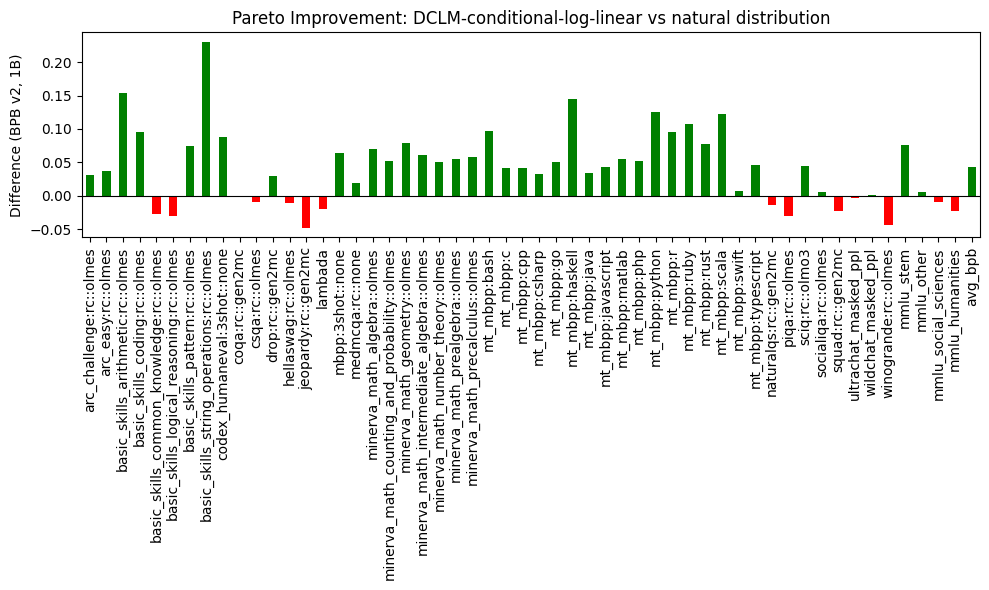

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = "1b-5xC-superswarm-v2-natural-52749eca"
target_name = "1b-5xC-superswarm-conditional-dclm-collapse-pes2o-log-linear-constraint-5-0b61d5af"

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: DCLM-conditional-log-linear vs natural distribution')
plt.ylabel('Difference (BPB v2, 1B)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Visualize latest proposed mixes

In [ ]:
def get_source_mix(mix):
    source_level = defaultdict(float)
    for source, weight in mix.items():
        if source.startswith("dclm:"):
            source_level["dclm"] += weight
        elif source.startswith("s2pdf:"):
            source_level["s2pdf"] += weight
        elif source.startswith("stack-edu:"):
            source_level["stack-edu"] += weight
        elif source.startswith("pes2o:"):
            source_level["pes2o"] += weight
        else: 
            if source in ['run', 'name', 'index']:
                continue
            source_level[source] += weight
    return source_level

In [179]:
def get_topic_mix(topic, mix):
    topic_weights = {k: v for k, v in mix.items() if k.startswith(topic + ":")}
    total_weight = sum(topic_weights.values())
    normalized_weights = {k: v / total_weight for k, v in topic_weights.items()}

    return normalized_weights

In [180]:
mixes = ratios[ratios.columns].to_dict(orient="records")

In [183]:
name_to_desc = {v: k for k, v in desc_to_name.items()}


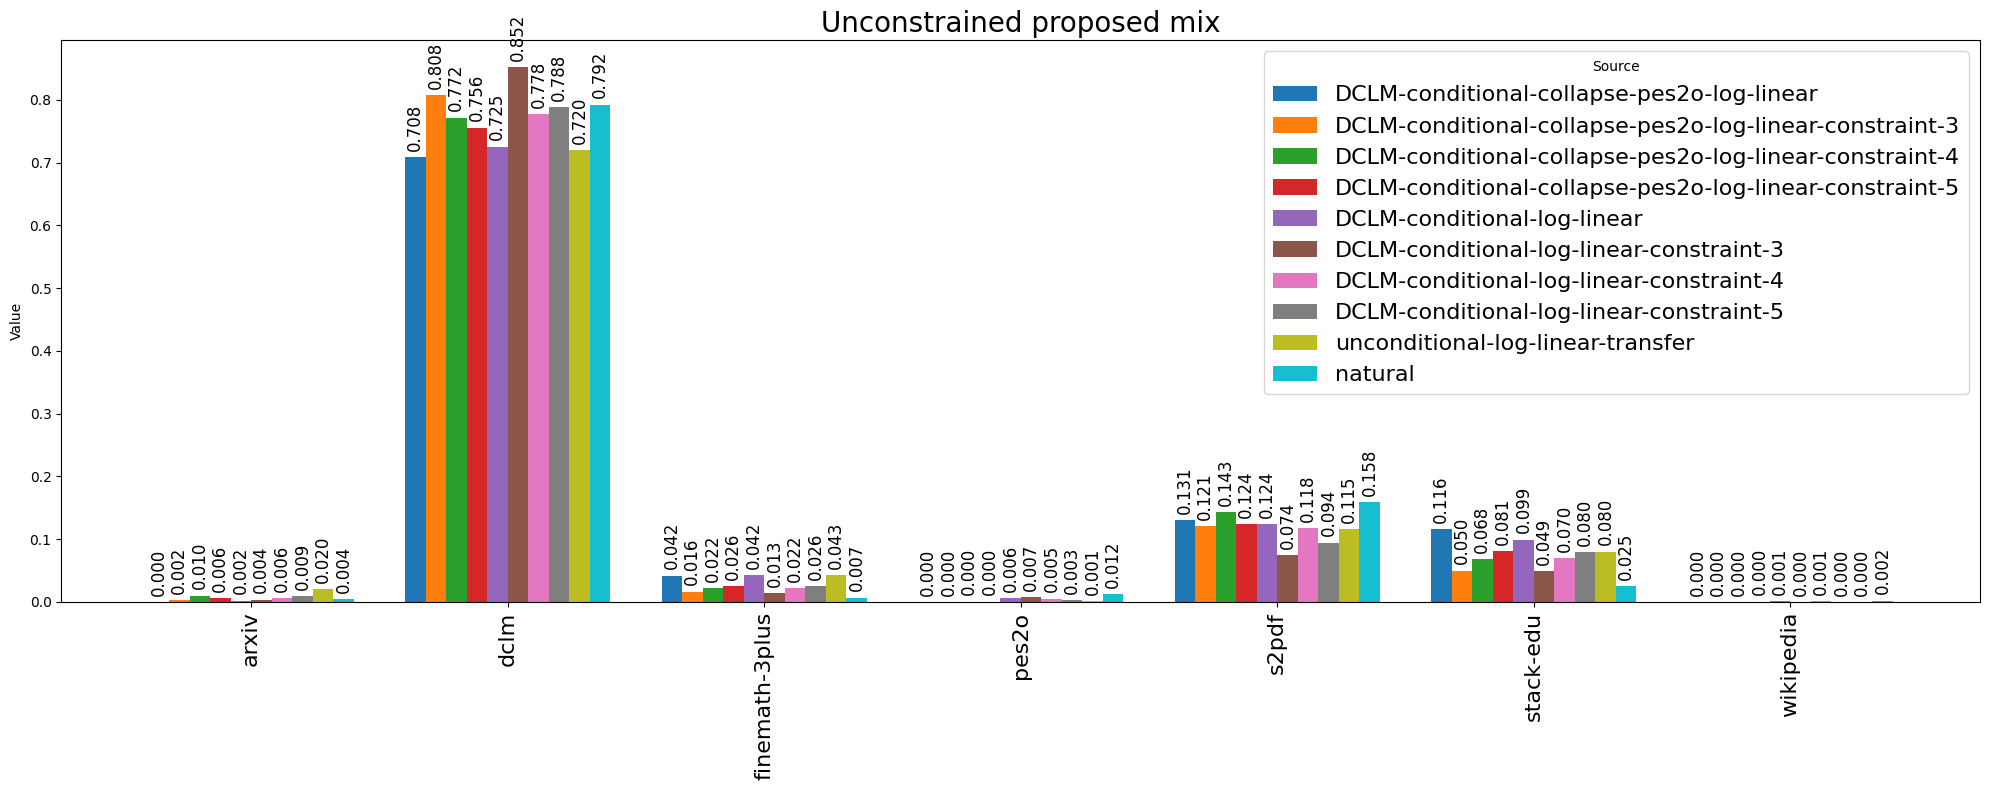

In [197]:
import matplotlib.pyplot as plt
import numpy as np

rep_source_mixes = {name_to_desc[mix['name']]: get_source_mix(mix) for mix in mixes}


del rep_source_mixes['natural']
del rep_source_mixes['DCLM-conditional-natural']

rep_source_mixes['natural'] = launch_config.manual_prior


# Step 2: Collect all unique keys
all_keys = sorted(set().union(*[d.keys() for d in rep_source_mixes.values()]))

# Step 3: Extract values for each dict, aligning with `all_keys`
values_matrix = [
    [d.get(k, 0) for k in all_keys]
    for d in rep_source_mixes.values()
]

# Step 4: Plot grouped bars with annotations
n_dicts = len(rep_source_mixes)
x = np.arange(len(all_keys))
bar_width = 0.8 / n_dicts

fig, ax = plt.subplots(figsize=(20, 8))

for i, (label, values) in enumerate(zip(rep_source_mixes.keys(), values_matrix)):
    offset = (i - (n_dicts - 1) / 2) * bar_width
    bars = ax.bar(x + offset, values, width=bar_width, label=label)

    # Annotate each bar
    for bar in bars:
        height = bar.get_height()
        #if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height+0.01,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=12,
            rotation=90
        )

# Step 5: Format the plot
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
ax.set_ylabel("Value")
ax.set_title("Unconstrained proposed mix", fontsize=20)
ax.legend(title="Source", fontsize=16, loc="upper right")
plt.tight_layout()
plt.show()

# Debug swarm issue

In [71]:
weights = [
 0.012172278723937446,
 0.0049381047491661445,
 0.00039705011709719926,
 0.004509121261299108,
 0.003295856673171901,
 0.007685385719810896,
 0.013965760761383804,
 0.001276573003614033,
 0.0011932978532442535,
 0.0033280287408051453,
 0.07509679163835054,
 0.020120485583005367,
 0.0032346845002245114,
 0.0020472392604962385,
 0.0014288768173446418,
 0.005928846314919813,
 0.0033163472292638274,
 0.015330689642855718,
 0.004410844193993947,
 0.01393839910359939,
 0.008667222435923801,
 0.00047822099379126435,
 0.00013448520883676645,
 0.0008373318977912773,
 0.0008824773810947093,
 0.0096392038883183,
 0.022549317798313696,
 0.03307159249562678,
 0.02662903265734908,
 0.07403465987510491,
 9.821691787776217e-05,
 0.03136966668142213,
 0.01086489230951611,
 0.0531536422106787,
 0.07668573844020471,
 0.020901574053908963,
 0.007116530434326095,
 0.012144976946322885,
 0.052643374250261436,
 0.01674040151093651,
 0.01524523503001552,
 0.16217254310022905,
 0.003583755401088272,
 0.03651335990637062,
 0.0859412254810032,
 0.010082762717873018,
 0.007557832875849439,
 0.0016948687072482183,
 0.015229428298781617
]


In [80]:
weight_dict = {
  'finemath-3plus': 0.012172278723937446,
  'arxiv': 0.0049381047491661445,
  'wikipedia': 0.00039705011709719926,
  's2pdf:crime_law': 0.004509121261299108,
  's2pdf:education_jobs': 0.003295856673171901,
  's2pdf:finance_business': 0.007685385719810896,
  's2pdf:health': 0.013965760761383804,
  's2pdf:industrial': 0.001276573003614033,
  's2pdf:politics': 0.0011932978532442535,
  's2pdf:religion': 0.0033280287408051453,
  's2pdf:science_tech': 0.07509679163835054,
  's2pdf:software_dev': 0.020120485583005367,
  's2pdf:software': 0.0032346845002245114,
  's2pdf:transportation': 0.0020472392604962385,
  'stack-edu:C': 0.0014288768173446418,
  'stack-edu:Cpp': 0.005928846314919813,
  'stack-edu:CSharp': 0.0033163472292638274,
  'stack-edu:Java': 0.015330689642855718,
  'stack-edu:JavaScript': 0.004410844193993947,
  'stack-edu:Markdown': 0.01393839910359939,
  'stack-edu:Python': 0.008667222435923801,
  'stack-edu:Shell': 0.00047822099379126435,
  'stack-edu:SQL': 0.00013448520883676645,
  'stack-edu:TypeScript': 0.0008373318977912773,
  'dclm:adult_content': 0.0008824773810947093,
  'dclm:art_and_design': 0.0096392038883183,
  'dclm:crime_and_law': 0.022549317798313696,
  'dclm:education_and_jobs': 0.03307159249562678,
  'dclm:electronics_and_hardware': 0.02662903265734908,
  'dclm:entertainment': 0.07403465987510491,
  'dclm:fashion_and_beauty': 9.821691787776217e-05,
  'dclm:finance_and_business': 0.03136966668142213,
  'dclm:food_and_dining': 0.01086489230951611,
  'dclm:games': 0.0531536422106787,
  'dclm:health': 0.07668573844020471,
  'dclm:history_and_geography': 0.020901574053908963,
  'dclm:home_and_hobbies': 0.007116530434326095,
  'dclm:industrial': 0.012144976946322885,
  'dclm:literature': 0.052643374250261436,
  'dclm:politics': 0.01674040151093651,
  'dclm:religion': 0.01524523503001552,
  'dclm:science_math_and_technology': 0.16217254310022905,
  'dclm:social_life': 0.003583755401088272,
  'dclm:software': 0.03651335990637062,
  'dclm:software_development': 0.0859412254810032,
  'dclm:sports_and_fitness': 0.010082762717873018,
  'dclm:transportation': 0.007557832875849439,
  'dclm:travel_and_tourism': 0.0016948687072482183,
  'pes2o': 0.015229428298781617
}


In [81]:
sum(list(weight_dict.values()))

0.9942782317936487

In [74]:
import yaml
with open("/home/mayee/re/year6/ai2/olmo-cookbook/src/cookbook/recipes/superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-constraint-3.yaml", "r") as f:
    launch_config = yaml.safe_load(f)



In [84]:
good_weights = {domain['name'] :domain['target_ratio'] for domain  in launch_config['dataset']['sources']}

In [89]:
for domain, w in good_weights.items():
    if w != 0 and domain not in weight_dict:
        print("zero", domain, w)

zero s2pdf:history 0.005721768206351222


In [50]:
ratios_path = "/home/mayee/re/year6/ai2/regmixer/cache/84313ca4_olmo3_offline_tasks_ratios.pkl"
metrics_path = "/home/mayee/re/year6/ai2/regmixer/cache/84313ca4_olmo3_offline_tasks_metrics.pkl"

import pickle 
with open(ratios_path, 'rb') as f:
    ratios = pickle.load(f)
with open(metrics_path, 'rb') as f:
    metrics = pickle.load(f)

In [48]:
ratios_path = "cache/ee28fc9c_superswarm_offline_ratios.pkl"
metrics_path = "cache/ee28fc9c_superswarm_offline_metrics.pkl"

import pickle 
with open(ratios_path, 'rb') as f:
    ratios = pickle.load(f)
with open(metrics_path, 'rb') as f:
    metrics = pickle.load(f)

In [54]:
ratios.iloc[3]

run                                                                nx134hdl
name                      5xC-30m-superswarm-dclm-conditional-v2-84313ca...
index                                                                     3
arxiv                                                              0.033504
finemath-3plus                                                     0.000689
pes2o                                                              0.039331
s2pdf:adult                                                             0.0
s2pdf:art_design                                                   0.018464
s2pdf:crime_law                                                         0.0
s2pdf:education_jobs                                                    0.0
s2pdf:entertainment                                                     0.0
s2pdf:fashion_beauty                                                    0.0
s2pdf:finance_business                                                  0.0
s2pdf:food_d

In [ ]:
ratios

In [53]:
ratios[ratios.columns[3:]].sum(axis=1).values

array([1.00345818, 1.        , 1.        , 1.01038601, 1.0019559 ,
       1.00642136, 1.        , 1.00385206, 1.        , 1.16262255,
       1.        , 1.00835739, 1.        , 1.        , 1.00043425,
       1.04617324, 1.        , 1.        , 1.01801219, 1.00740867,
       1.        , 1.        , 1.        , 1.        , 1.01121691,
       1.        , 1.00132878, 1.        , 1.01471005, 1.00181249,
       1.        , 1.00147022, 1.        , 1.        , 1.        ,
       1.        , 1.00321032, 1.        , 1.00873851, 1.07599391,
       1.00156822, 1.00300331, 1.        , 1.00916459, 1.03685881,
       1.        , 1.0293334 , 1.        , 1.00188916, 1.01177686,
       1.        , 1.00138897, 1.        , 1.        , 1.        ,
       1.00407308, 1.        , 1.        , 1.00041454, 1.        ,
       1.03623423, 1.00490978, 1.01293356, 1.01235032, 1.02138286,
       1.        , 1.        , 1.        , 1.        , 1.00994919,
       1.00029251, 1.00083429, 1.05405951, 1.0002506 , 1.     